# transform consistency of attention distribution 2021.5.16

## dataset construct

dataset (42872, 3456, 7)
labelset (42872, 3)
train_data (17120, 3456, 7)
train_data (17120, 2304, 7)
test_data_1 (4280, 2304, 7)
test_data_2 (4280, 2304, 7)


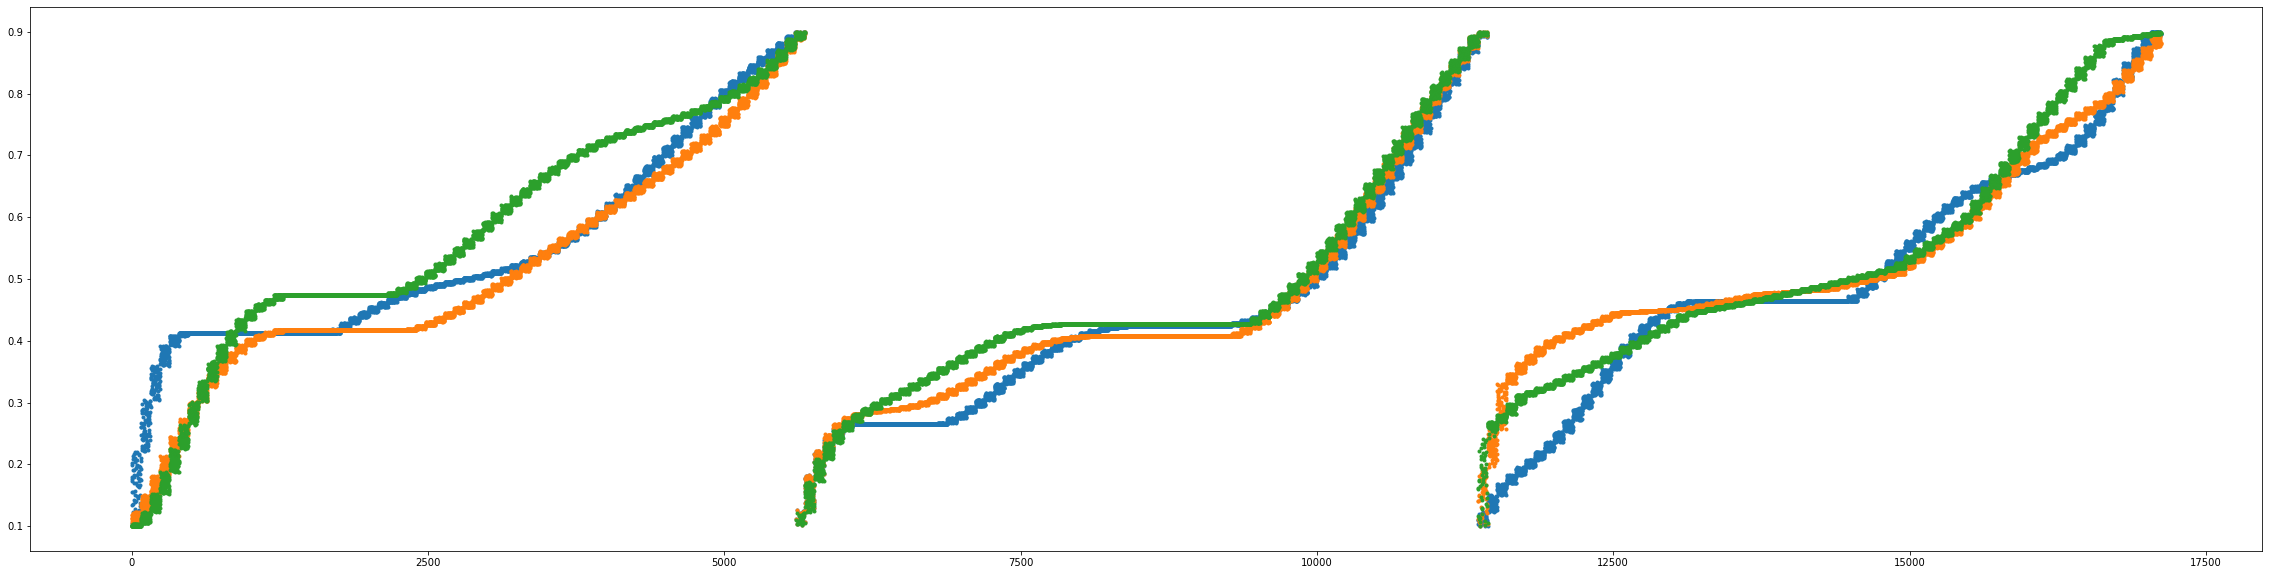

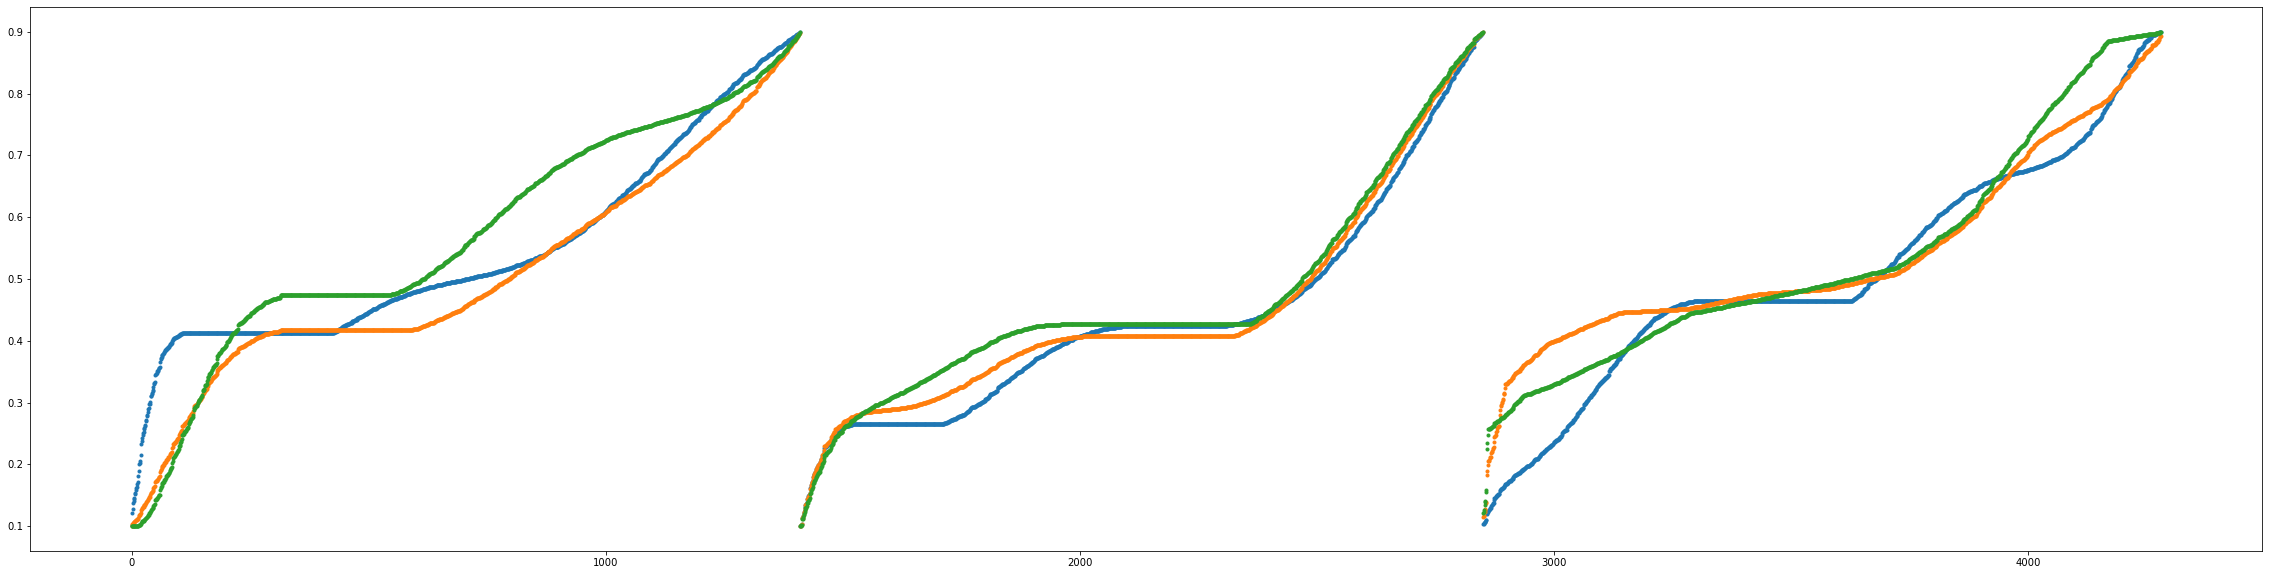

time1 =   528.3508675098419


In [1]:
#数据集构建
#corresponding to dataset_8. The difference is the sample length is longer at first. But the length is cut into the same before. 
# This is to facilitate the construction of test samples with positional deviations. 2021.5.16
#input: 3 original signal set and correponding label set.
#output: training set, test set, test set with positional deviation

import numpy as np
import pandas as pd
import random
import scipy.signal
import time
import xlrd
import os
import matplotlib.pyplot as plt

INTERPOLATION_NUM = 50
TIME_STEPS_2=3456    #提取的序列长度
TIME_STEPS=2592    #start范围+序列长度
OUTPUT_STEPS=2304   #序列长度
DATA_CHANNEL=7      #读取原始数据集的通道数

DATA_LOADPATH = ['tool_wear/c1/c1/c_1_', 'tool_wear/c4/c4/c_4_', 'tool_wear/c6/c6/c_6_']
LABEL_LOADPATH = ['tool_wear/c1_wear.xls', 'tool_wear/c4_wear.xls', 'tool_wear/c6_wear.xls']

TRAINDATA_SAVEPATH = 'tool_wear_data_8/train_data.npy' #训练集数据存储路径
TRAINLABEL_SAVEPATH = 'tool_wear_data_8/train_label.npy' #训练集标签存储路径
TESTDATA1_SAVEPATH = 'tool_wear_data_8/test_data1.npy' #验证集数据存储路径
TESTDATA2_SAVEPATH = 'tool_wear_data_8/test_data2.npy' #验证集数据存储路径
TESTLABEL_SAVEPATH =  'tool_wear_data_8/test_label.npy' #验证集标签存储路径

####################################数据读取及处理###################################################################################
#将输入转化为LSTM可用的数据格式[-1, time, item]，插值。输出格式符合[-1, item]，不做改变,若作改变函数详见SOC_LSTM_prediction
#两边的删除量可能需要根据数据段的长短调节，现数值两边各2%
def generate(seq_X):
    X=[]
    total_num = np.shape(seq_X)[0]
    for i in range(INTERPOLATION_NUM-4):
        X.append([seq_X[round(total_num*(i+2+1)/INTERPOLATION_NUM)-TIME_STEPS_2 : round(total_num*(i+2+1)/INTERPOLATION_NUM)]])#去除头尾            
    return np.array(X,dtype=np.float32)

#将原数据按比例随机分为训练集和测试集两部分，ratio测试集占比
def set_segmentation(data, ratio, label):
    segment_length = 100             #单个随机抽样区域长度
    total_num = np.shape(label)[0]
    data = np.array(data[:total_num-total_num%segment_length])
    label = np.array(label[:total_num-total_num%segment_length])
    train_label = []
    train_data = []
    train_index = []
    for i in range(0, total_num-segment_length, segment_length):
        index = random.sample(range(i,i+segment_length), int(segment_length*(1-ratio)))
        train_label.extend(label[index])
        train_data.extend(data[index])
        train_index.extend(index)
    test_label = np.delete(label, train_index, axis = 0)
    test_data = np.delete(data, train_index, axis = 0)
    return train_data, train_label, test_data, test_label

#读取训练集或验证集数据
def dataset_read(data_path, label_path):
    for j in range(len(data_path)):
        #读取label
        workbook = xlrd.open_workbook(label_path[j])
        sheet1 = workbook.sheet_by_index(0)         #用索引取第一个sheet
        #numpy运算先转array，需变二维矩阵，除去第一组label
        label = np.transpose(np.concatenate([np.array([sheet1.col_values(0)]), 
                                             np.array([sheet1.col_values(1)]), 
                                             np.array([sheet1.col_values(2)])], axis=0))[1: -INTERPOLATION_NUM]
        label = label.astype(np.float32)
        delete_index1 = []

        #读取data
        for i in range(2, 315):   #忽略首次和末次切割
            if i < 10:
                data_path1 = data_path[j] + '00' + str(i) + '.csv'
            elif i >= 10 and i < 100:
                data_path1 = data_path[j] + '0' + str(i) + '.csv'
            else:
                data_path1 = data_path[j] + str(i) + '.csv'

            if os.path.getsize(data_path1):  #检验是否为空文件
                train_data_read = pd.read_csv(data_path1, header = None)#这里可加入预处理环节
#                 train_data_read = scipy.signal.medfilt(train_data_read, [3, 1])[::2, 0:DATA_CHANNEL]
                train_data_read = np.array(train_data_read)[:, 0:DATA_CHANNEL]

                if i > 2:  #i的循环起始数，起始循环数+1
                    X_train = np.concatenate([X_train, generate(train_data_read)])
                else:
                    X_train = generate(train_data_read)
            else:
                delete_index1 = np.append(delete_index1, list(range((i-2)*INTERPOLATION_NUM, (i-1)*INTERPOLATION_NUM, 1)))
        
        label = np.delete(label,np.int32(delete_index1),axis = 0)
        delete_index = list(range(0, np.shape(label)[0], INTERPOLATION_NUM)) + \
                                    list(range(1, np.shape(label)[0], INTERPOLATION_NUM)) + \
                                    list(range(2, np.shape(label)[0], INTERPOLATION_NUM)) + \
                                    list(range(49, np.shape(label)[0], INTERPOLATION_NUM))
        label = np.delete(label, delete_index, axis = 0)
        X_train=np.reshape(X_train, [-1, TIME_STEPS_2, np.shape(train_data_read)[1]])

        max_val = np.max(label, 0)
        min_val = np.min(label, 0)
        label = (label - min_val)/(max_val - min_val)*0.8 + 0.1
    
        if j > 0:
            label1 = np.vstack([label1, label])
            X_train1 = np.vstack([X_train1, X_train])
        else:
            label1 = label
            X_train1 = X_train
    return X_train1, label1

def signal_start_detection(signal):
    output_signal = np.zeros([np.shape(signal)[0], OUTPUT_STEPS, np.shape(signal)[2]])
    for i in range(np.shape(signal)[0]):
        min_index = np.argmin(signal[i, :TIME_STEPS-OUTPUT_STEPS-1, 0])
        output_signal[i] = signal[i, min_index : min_index+OUTPUT_STEPS]
    return output_signal

###################################数据存储##########################################################################################
time_start = time.time()
dataset, labelset = dataset_read(DATA_LOADPATH, LABEL_LOADPATH)
print('dataset', np.shape(dataset))
print('labelset', np.shape(labelset))
dataset = dataset[::2]
labelset = labelset[::2]
train_data, train_label, test_data, test_label = set_segmentation(dataset, 0.2, labelset)
train_data = np.array(train_data)
print('train_data', np.shape(train_data))

train_data = signal_start_detection(train_data)
print('train_data', np.shape(train_data))

test_data = np.array(test_data)
test_data_1 = signal_start_detection(test_data)
test_data_2 = signal_start_detection(test_data[:, -TIME_STEPS:])
print('test_data_1', np.shape(test_data_1))
print('test_data_2', np.shape(test_data_2))

plt.figure(figsize=(40, 10))
plt.plot(train_label, '.')
plt.show()
plt.figure(figsize=(40, 10))
plt.plot(test_label, '.')
plt.show()

np.save(TRAINDATA_SAVEPATH,train_data)
np.save(TRAINLABEL_SAVEPATH,train_label)
np.save(TESTDATA1_SAVEPATH,test_data_1)
np.save(TESTDATA2_SAVEPATH,test_data_2)
np.save(TESTLABEL_SAVEPATH,test_label)

print('time1 =  ', time.time()-time_start)


X_train (29960, 2304, 7)
Y_train (29960, 3)
X_train_small (2996, 2304, 7)
Y_train_small (2996, 3)
X_test1_small (1284, 2304, 7)
X_test2_small (1284, 2304, 7)


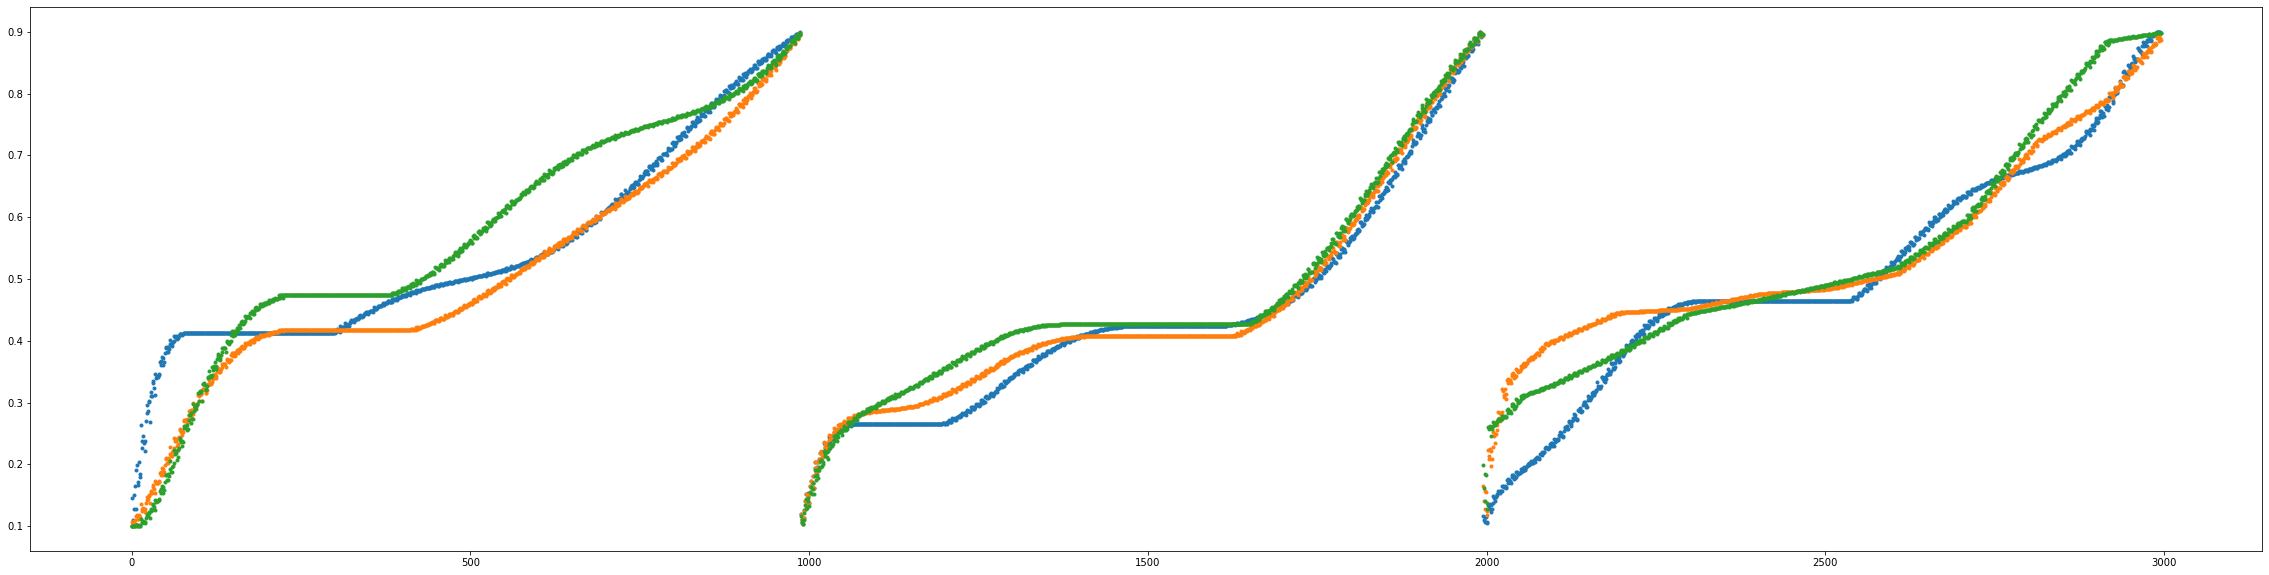

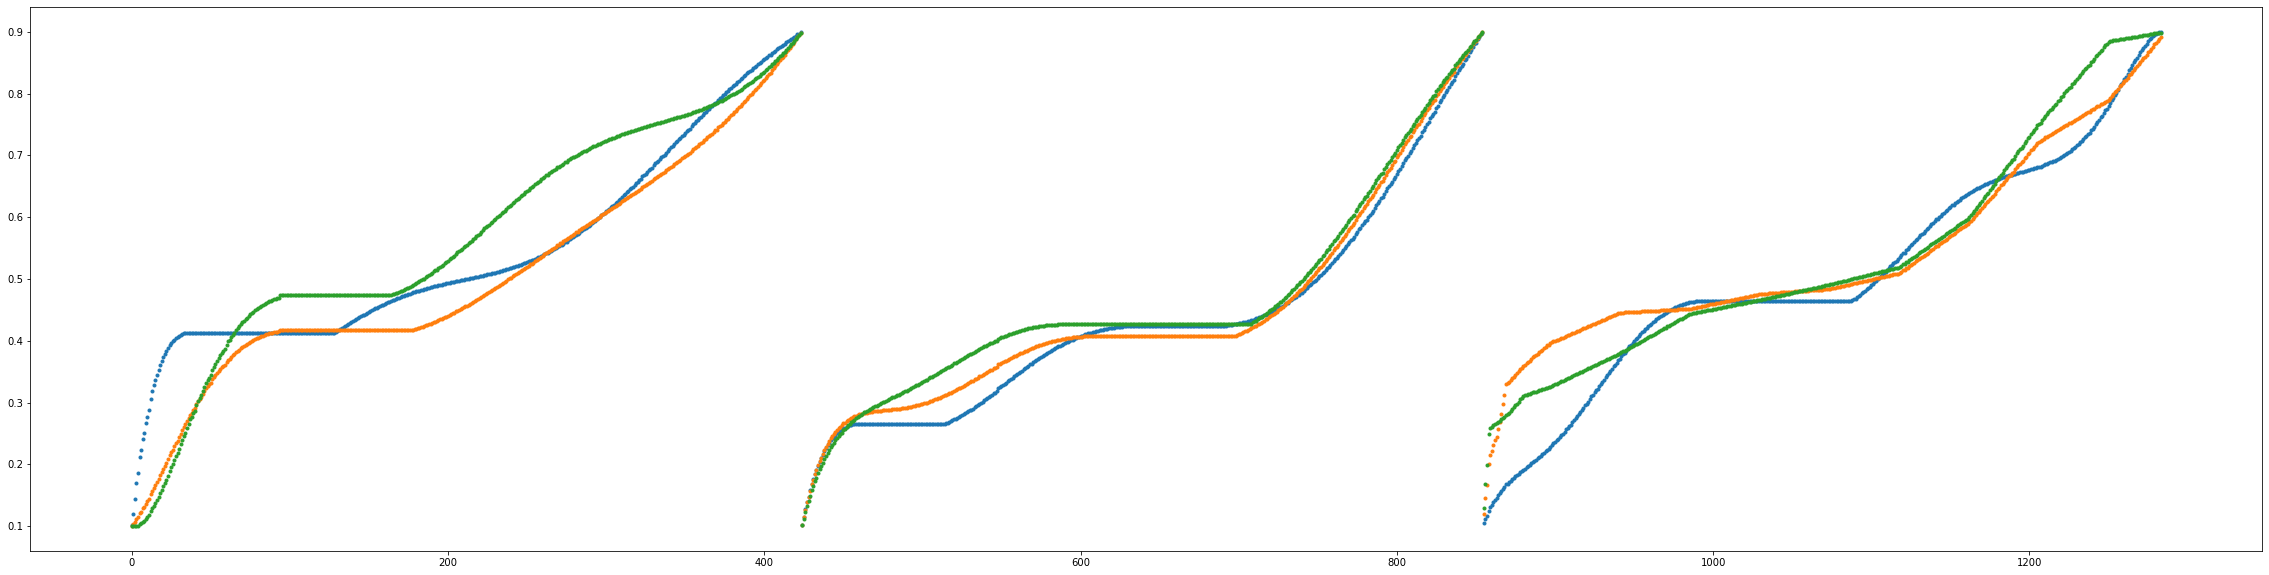

In [2]:
# 小数据集构建，便于显示

import numpy as np
import matplotlib.pyplot as plt
import os
import time

TRAINDATA_LOADPATH = 'tool_wear_data_7/train_data.npy'
TRAINLABEL_LOADPATH = 'tool_wear_data_7/train_label.npy'
TESTDATA1_LOADPATH = 'tool_wear_data_7/test_data1.npy'
TESTDATA2_LOADPATH = 'tool_wear_data_7/test_data2.npy'
TESTLABEL_LOADPATH =  'tool_wear_data_7/test_label.npy'

TRAINDATA_SAVEPATH = 'tool_wear_data_7_small/train_data.npy'
TRAINLABEL_SAVEPATH = 'tool_wear_data_7_small/train_label.npy'
TESTDATA1_SAVEPATH = 'tool_wear_data_7_small/test_data1.npy'
TESTDATA2_SAVEPATH = 'tool_wear_data_7_small/test_data2.npy'
TESTLABEL_SAVEPATH =  'tool_wear_data_7_small/test_label.npy'

################################################### 数据集读取及处理 ##################################################
X_train=np.load(TRAINDATA_LOADPATH)
Y_train=np.load(TRAINLABEL_LOADPATH)
X_test1=np.load(TESTDATA1_LOADPATH)
X_test2=np.load(TESTDATA2_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)

X_train_small = X_train[::10]
Y_train_small = Y_train[::10]
X_test1_small = X_test1[::10]
X_test2_small = X_test2[::10]
Y_test_small = Y_test[::10]
print('X_train', np.shape(X_train))
print('Y_train', np.shape(Y_train))
print('X_train_small', np.shape(X_train_small))
print('Y_train_small', np.shape(Y_train_small))
print('X_test1_small', np.shape(X_test1_small))
print('X_test2_small', np.shape(X_test2_small))

plt.figure(figsize=(40, 10))
plt.plot(Y_train_small, '.')
plt.show()
plt.figure(figsize=(40, 10))
plt.plot(Y_test_small, '.')
plt.show()

np.save(TRAINDATA_SAVEPATH, X_train_small)
np.save(TRAINLABEL_SAVEPATH, Y_train_small)
np.save(TESTDATA1_SAVEPATH, X_test1_small)
np.save(TESTDATA2_SAVEPATH, X_test2_small)
np.save(TESTLABEL_SAVEPATH, Y_test_small)

## 模型训练

In [1]:
# 模型在training set训练完成后，应用于具有一定偏移的测试集信号，观察模型的注意力偏移

# 一维离散小波变换，模型存储
# 对不同传感器信号采用不同的小波级数和频带，降低输入通道数 2020.10.24
# 运行环境 anaconda 1.10.0, python 3.8.5 tensorflow 2.4.0, numpy 1.19.2, pywt 1.1.1, matplotlib 3.3.2
# i5-8400 8GB  

import pywt
import numpy as np

import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend, regularizers
import time

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

TRAINDATA_LOADPATH = 'tool_wear_data_7/train_data.npy'
TRAINLABEL_LOADPATH = 'tool_wear_data_7/train_label.npy'
TESTDATA1_LOADPATH = 'tool_wear_data_7/test_data1.npy'
TESTDATA2_LOADPATH = 'tool_wear_data_7/test_data2.npy'
TESTLABEL_LOADPATH =  'tool_wear_data_7/test_label.npy'
SUMMARY_PATH = './logs'     #记录路径
MODEL_SAVE_PATH = 'attention_distribution_dataset10/model.h5'
MODEL_SAVE_PATH2 = 'attention_distribution_dataset10/model2.h5'

#信号层级关系
SIGNAL_LENGTH_1 = 2304
SIGNAL_LENGTH_2 = 48
SIGNAL_LENGTH_3 = 8

#输入数据
INPUT_SIZE = [SIGNAL_LENGTH_1, 7]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
SCALE_NUM_VIBRATION = 3 #小波分解级数
SCALE_NUM_AE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'
# NOISE_FILTER_PERCENT = 90

LOWFREQ_INPUT_SIZE = [int(SIGNAL_LENGTH_1/8), 7]
LOWFREQ_LSTM_SIZE = 18
LOWFREQ_FEATURE_SIZE = 20
ATTENTION_SIZE = 23

HIGHFREQ_INPUT_SIZE = [SIGNAL_LENGTH_1, 6]
HIGHFREQ_LSTM_SIZE = 18
# LOWFREQ_FEATURE_SIZE = ATTENTION_SIZE
ATTENTION_RANGE = 48 #需要与splicing的个数对应
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
SAMPLING_STEP = LOWFREQ_INPUT_SIZE[0]/SIGNAL_LENGTH_2

LOCAL_INPUT_SIZE = [SIGNAL_LENGTH_2, LOWFREQ_FEATURE_SIZE+ATTENTION_SIZE]
LOCAL_TIMESTEP = int(SIGNAL_LENGTH_2/SIGNAL_LENGTH_3) #???
LOCAL_LSTM_SIZE = 25
LOCAL_DENSE_SIZE = 30

GLOBAL_INPUT_SIZE = [SIGNAL_LENGTH_3, LOCAL_DENSE_SIZE]
GLOBAL_LSTM_SIZE = 28
GLOBAL_DENSE_SIZE = 35

PREDICT_DENSE_SIZE = 200
OUTPUT_SIZE = 3

BATCH_SIZE = 64
PREDICTOR_TRAIN_BATCH1 = 8
PREDICTOR_TRAIN_BATCH2 = 3


##############################数据集读取########################################
X_train=np.load(TRAINDATA_LOADPATH)
Y_train=np.load(TRAINLABEL_LOADPATH)
X_test1=np.load(TESTDATA1_LOADPATH)
X_test2=np.load(TESTDATA2_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)

#validation_split将样本集按先后比例分为训练集合样本集，样本数量应为两者和的整数倍
X_train = X_train[:(np.shape(X_train)[0]-np.shape(X_train)[0]%BATCH_SIZE), :,:INPUT_NUM]
Y_train = Y_train[:(np.shape(Y_train)[0]-np.shape(Y_train)[0]%BATCH_SIZE), :OUTPUT_SIZE]
X_test1 = X_test1[:(np.shape(X_test1)[0]-np.shape(X_test1)[0]%BATCH_SIZE), :,:INPUT_NUM]
X_test2 = X_test2[:(np.shape(X_test2)[0]-np.shape(X_test2)[0]%BATCH_SIZE), :,:INPUT_NUM]
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]

############################################################小波分析##########################################################################################
def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

#         plt.figure(figsize=(30,2))
#         plt.plot(data[sample_index, :1024, j])
#         plt.show()
#         plt.figure(figsize=(30,2))
#         plt.plot(coeffs_lowfreq[sample_index, :128])
#         plt.show()
#         plt.figure(figsize=(30,2))
#         plt.plot(coeffs_highfreq[sample_index, :1024])
#         plt.show()
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

coeffs_train_force = wavelet_transform(X_train[:, :, 0:3], SCALE_NUM_FORCE)
coeffs_train_vibration = wavelet_transform(X_train[:, :, 3:6], SCALE_NUM_VIBRATION)
coeffs_train_AE = wavelet_transform(X_train[:, :, 6].reshape([np.shape(X_train)[0], np.shape(X_train)[1], 1]), SCALE_NUM_AE)
coeffs_train_AE = coeffs_train_AE[0]
coeffs_lowfreq_train = np.concatenate([coeffs_train_force[0], coeffs_train_vibration[0], coeffs_train_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
coeffs_highfreq_train = np.concatenate([coeffs_train_force[1], coeffs_train_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
print('coeffs_lowfreq_train', np.shape(coeffs_lowfreq_train))
print('coeffs_highfreq_train', np.shape(coeffs_highfreq_train))
print('Y_train', np.shape(Y_train))

coeffs_test_force = wavelet_transform(X_test1[:, :, 0:3], SCALE_NUM_FORCE)
coeffs_test_vibration = wavelet_transform(X_test1[:, :, 3:6], SCALE_NUM_VIBRATION)
coeffs_test_AE = wavelet_transform(X_test1[:, :, 6].reshape([np.shape(X_test1)[0], np.shape(X_test1)[1], 1]), SCALE_NUM_AE)
coeffs_test_AE = coeffs_test_AE[0]
coeffs_lowfreq_test1 = np.concatenate([coeffs_test_force[0], coeffs_test_vibration[0], coeffs_test_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
coeffs_highfreq_test1 = np.concatenate([coeffs_test_force[1], coeffs_test_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
print('coeffs_lowfreq_test1', np.shape(coeffs_lowfreq_test1))
print('coeffs_highfreq_test1', np.shape(coeffs_highfreq_test1))

coeffs_test_force = wavelet_transform(X_test2[:, :, 0:3], SCALE_NUM_FORCE)
coeffs_test_vibration = wavelet_transform(X_test2[:, :, 3:6], SCALE_NUM_VIBRATION)
coeffs_test_AE = wavelet_transform(X_test2[:, :, 6].reshape([np.shape(X_test2)[0], np.shape(X_test2)[1], 1]), SCALE_NUM_AE)
coeffs_test_AE = coeffs_test_AE[0]
coeffs_lowfreq_test2 = np.concatenate([coeffs_test_force[0], coeffs_test_vibration[0], coeffs_test_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
coeffs_highfreq_test2 = np.concatenate([coeffs_test_force[1], coeffs_test_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
print('coeffs_lowfreq_test2', np.shape(coeffs_lowfreq_test2))
print('coeffs_highfreq_test2', np.shape(coeffs_highfreq_test2))
print('Y_test', np.shape(Y_test))

##############################################################################################频带模型搭建###############################################################
def lowfreq_model_construct(input_size, rnn_size, output_size, attention_size, name):
# 双层双向GRU提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='lowfreq_inputs')
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)
    x = layers.Lambda(lambda x: x[:, ::6])(x)# 剔除冗余的 dual-scale 的输出。这里进行了降采样
    outputs = layers.TimeDistributed(layers.Dense(output_size))(x)
    outputs = layers.TimeDistributed(layers.LeakyReLU())(outputs)
    query = layers.TimeDistributed(layers.Dense(attention_size))(x)
    query = layers.TimeDistributed(layers.LeakyReLU())(query)
    query = layers.LayerNormalization(axis = 1)(query)
    model_lowfreq = models.Model(inputs=inputs, outputs=[outputs, query], name = name)
    return model_lowfreq

def highfreq_model_construct(input_size, rnn_size, attention_size, name):
# 双层双向GRU提取邻域特征，送入dense层得到low_frequency_feature和query
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='highfreq_inputs')
#     x = layers.Lambda(adjust_range, name = 'adjust_range')(inputs)
    x = layers.Bidirectional(layers.LSTM(rnn_size, return_sequences=True, name='biLSTM'))(inputs)#, recurrent_regularizer=regularizers.l1(0.000001)
    key = layers.TimeDistributed(layers.Dense(attention_size))(x)
    key = layers.TimeDistributed(layers.LeakyReLU())(key)
    value = layers.TimeDistributed(layers.Dense(attention_size))(x)
    value = layers.TimeDistributed(layers.LeakyReLU())(value)
    key = layers.LayerNormalization(axis = 1)(key)
    value = layers.LayerNormalization(axis = 1)(value)
    model_highfreq = models.Model(inputs=inputs, outputs=[key, value], name = name)
    return model_highfreq

class lowhigh_freq_Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(lowhigh_freq_Attention,self).__init__(**kwargs) 
    def build(self, input_shape): 
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x): 
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value = tf.transpose(value, [0, 2, 1])
        value_weighted = value * distribution
        value_weighted = tf.reduce_sum(value_weighted, axis=2)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE)
    
class temporal_Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(temporal_Attention,self).__init__(**kwargs) 
    def build(self, input_shape): 
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        super(temporal_Attention,self).build(input_shape)
    def call(self, key):
        scores = tf.matmul(self.u_query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        key = tf.transpose(key, [0, 2, 1])
        value_weighted = key * distribution
        value_weighted = tf.reduce_sum(value_weighted, axis=2)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])

#高低频时序特征提取
input_lowfreq = layers.Input(shape=LOWFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_lowfreq')
input_highfreq = layers.Input(shape=HIGHFREQ_INPUT_SIZE, batch_size = BATCH_SIZE, name='input_highfreq')
model_lowfreq = lowfreq_model_construct(LOWFREQ_INPUT_SIZE, LOWFREQ_LSTM_SIZE, LOWFREQ_FEATURE_SIZE, ATTENTION_SIZE, 'lowfreq_model')
model_highfreq = highfreq_model_construct(HIGHFREQ_INPUT_SIZE, HIGHFREQ_LSTM_SIZE, ATTENTION_SIZE, 'highfreq_model')
# 低频特征构造query，高频特征构造key和value，构建低频特征向高频特征的注意力模型，使高低频长度一致并对齐
feature_lowfreq, query = model_lowfreq(input_lowfreq)
key, value = model_highfreq(input_highfreq)

#高低频注意力机制
query = layers.Reshape([-1, 1, ATTENTION_SIZE])(query)
value = layers.Reshape([-1, int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), ATTENTION_SIZE])(value)
key = layers.Reshape([-1, int(HIGHFREQ_INPUT_SIZE[0]/ATTENTION_RANGE), ATTENTION_SIZE])(key)
concate_vector = layers.Concatenate(axis = 2)([query, value, key])
feature_highfreq, att_distribution_lowhigh = layers.TimeDistributed(lowhigh_freq_Attention())(concate_vector)
feature_freq = layers.Concatenate(axis = 2)([feature_lowfreq, feature_highfreq])

###############################################LSTM模型搭建###############################################################
def localLSTM_construct(input_size, timestep, lstm_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='input')
    x = layers.Reshape([int(input_size[0]/timestep), timestep, input_size[1]])(inputs)
    x = layers.TimeDistributed(layers.Bidirectional(layers.LSTM(lstm_size, return_sequences=True, name='biLSTM1')))(x)
    x = layers.Reshape([-1, lstm_size*2])(x)
    x = layers.TimeDistributed(layers.Dense(dense_size))(x)
    x = layers.TimeDistributed(layers.LeakyReLU())(x)
    x = layers.Reshape([int(input_size[0]/timestep), timestep, dense_size])(x)
    x = layers.LayerNormalization(axis = 2)(x)
    outputs, att_distribution_local = layers.TimeDistributed(temporal_Attention())(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=[outputs, att_distribution_local], name = name)
    return biLSTM_model

biLSTM_local = localLSTM_construct(LOCAL_INPUT_SIZE, LOCAL_TIMESTEP, LOCAL_LSTM_SIZE, LOCAL_DENSE_SIZE, 'biLSTM_local')
feature_local, att_distribution_local = biLSTM_local(feature_freq)
print('feature_local', feature_local)

def globalLSTM_construct(input_size, lstm_size, dense_size, name):
# biLSTM model construction
    inputs = layers.Input(shape=input_size, batch_size = BATCH_SIZE, name='input')
    x = layers.Bidirectional(layers.LSTM(lstm_size, return_sequences=False, name='biLSTM1'))(inputs)
    x = layers.Dense(dense_size)(x)
    outputs = layers.LeakyReLU()(x)
    biLSTM_model = models.Model(inputs=inputs, outputs=outputs, name = name)
    return biLSTM_model

biLSTM_global = globalLSTM_construct(GLOBAL_INPUT_SIZE, GLOBAL_LSTM_SIZE, GLOBAL_DENSE_SIZE, 'biLSTM_global')
feature = biLSTM_global(feature_local)
print('feature', feature)
x = layers.Dense(PREDICT_DENSE_SIZE)(feature)
x = layers.LeakyReLU()(x)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(OUTPUT_SIZE, name='output')(x)
output = layers.LeakyReLU()(x)
predictor = models.Model(inputs=[input_lowfreq, input_highfreq], outputs=output, name='tool_wear_predictor')
att_distribution_model = models.Model(inputs=[input_lowfreq, input_highfreq], 
                                      outputs=[att_distribution_lowhigh, att_distribution_local], 
                                      name = 'att_distribution_model')

predictor.summary()
#############################################模型训练#########################################################################
time_start = time.time()

adam = keras.optimizers.Adam(lr=0.008)
predictor.compile(optimizer=adam, loss = 'mse')

history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, batch_size=BATCH_SIZE, 
                        validation_data = ([coeffs_lowfreq_test1, coeffs_highfreq_test1], Y_test),
                        epochs=PREDICTOR_TRAIN_BATCH1,  shuffle=True, verbose=1)

adam = keras.optimizers.Adam(lr=0.001)
predictor.compile(optimizer=adam, loss = 'mse')
history = predictor.fit([coeffs_lowfreq_train, coeffs_highfreq_train], Y_train, batch_size=BATCH_SIZE, 
                        validation_data = ([coeffs_lowfreq_test1, coeffs_highfreq_test1], Y_test),
                        epochs=PREDICTOR_TRAIN_BATCH2,  shuffle=True, verbose=1)

predictor.save(MODEL_SAVE_PATH)
att_distribution_model.save(MODEL_SAVE_PATH2)
print('time1 =  ', time.time()-time_start)


coeffs_lowfreq_train (29952, 288, 7)
coeffs_highfreq_train (29952, 2304, 6)
Y_train (29952, 3)
coeffs_lowfreq_test1 (12800, 288, 7)
coeffs_highfreq_test1 (12800, 2304, 6)
coeffs_lowfreq_test2 (12800, 288, 7)
coeffs_highfreq_test2 (12800, 2304, 6)
Y_test (12800, 3)
feature_local KerasTensor(type_spec=TensorSpec(shape=(64, 8, 30), dtype=tf.float32, name=None), name='biLSTM_local/time_distributed_12/transpose_1:0', description="created by layer 'biLSTM_local'")
feature KerasTensor(type_spec=TensorSpec(shape=(64, 35), dtype=tf.float32, name=None), name='biLSTM_global/leaky_re_lu_5/LeakyRelu:0', description="created by layer 'biLSTM_global'")
Model: "tool_wear_predictor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lowfreq (InputLayer)      [(64, 288, 7)]       0                                            
____________________________

## 结果显示

In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
import pywt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    # 这一行注释掉就是使用gpu
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, backend
import time

from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.compat.v1.keras.backend import set_session
tf.keras.backend.clear_session()  # For easy reset of notebook state.
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9)
config_proto = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off 
sess = tf.compat.v1.Session(config=config_proto)
set_session(sess)

TRAINDATA_LOADPATH = 'tool_wear_data_8/train_data.npy'
TRAINLABEL_LOADPATH =  'tool_wear_data_8/train_label.npy'
TESTDATA1_LOADPATH = 'tool_wear_data_8/test_data1.npy'
TESTDATA2_LOADPATH = 'tool_wear_data_8/test_data2.npy'
TESTLABEL_LOADPATH =  'tool_wear_data_8/test_label.npy'

# MODEL_LOAD_PATH = 'attention_distribution_dataset9/model.h5'
# MODEL_LOAD_PATH2 = 'attention_distribution_dataset9/model2.h5'

# MODEL_LOAD_PATH = 'attention_distribution_dataset10/model.h5'
# MODEL_LOAD_PATH2 = 'attention_distribution_dataset10/model2.h5'

MODEL_LOAD_PATH = 'attention_distribution_dataset11/model.h5'
MODEL_LOAD_PATH2 = 'attention_distribution_dataset11/model2.h5'

#输入数据
INPUT_SIZE = [2304, 7]  #[time_steps, input_vector]
INPUT_NUM = INPUT_SIZE[1]

SCALE_NUM_FORCE = 3 #小波分解级数
SCALE_NUM_VIBRATION = 3 #小波分解级数
SCALE_NUM_AE = 3 #小波分解级数
WAVELET_HIGHFREQ = 'db2'
WAVELET_LOWFREQ = 'db6'

ATTENTION_RANGE = 48
OUTPUT_SIZE = 3
BATCH_SIZE = 64
size = 15

#################################################模型加载###################################################
class lowhigh_freq_Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(lowhigh_freq_Attention,self).__init__(**kwargs)
    def build(self, input_shape): 
        super(lowhigh_freq_Attention,self).build(input_shape)
    def call(self, x):
        query = x[:, 0]
        query = tf.expand_dims(query, axis=1)
        value = x[:, 1:ATTENTION_RANGE+1]
        key = x[:, ATTENTION_RANGE+1:]
        scores = tf.matmul(query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.matmul(distribution, value)
        value_weighted = tf.reduce_sum(value_weighted, axis=1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], ATTENTION_RANGE)
    
class temporal_Attention(layers.Layer):
    def __init__(self, **kwargs):
        super(temporal_Attention,self).__init__(**kwargs) 
    def build(self, input_shape): 
        self.u_query=self.add_weight(name='u_query',shape=[1, input_shape[2]], trainable=True, initializer='uniform')
        super(temporal_Attention,self).build(input_shape)
    def call(self, key): 
        scores = tf.matmul(self.u_query, key, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis = 2)
        value_weighted = tf.squeeze(tf.matmul(distribution, key), axis = 1)
        attention_distribution = tf.squeeze(distribution)
        return value_weighted, attention_distribution
    def compute_output_shape(self,input_shape):
        return (input_shape[0], input_shape[2]), (input_shape[0], input_shape[1])

def wavelet_transform(data, scale_num):
    coeffs = np.arange(2).tolist()
    for j in range(np.shape(data)[2]):
        sample = data[:, :, j].reshape([-1, np.shape(data)[1]])
        coeffs_lowfreq = pywt.wavedec(sample, WAVELET_LOWFREQ, 'symmetric', level=scale_num) #低频部分采用消失矩高的小波
        coeffs_lowfreq = coeffs_lowfreq[0][:, 7:-2] #低频
        coeffs_highfreq = pywt.wavedec(sample, WAVELET_HIGHFREQ, 'symmetric', level=scale_num) #高频部分采用消失矩低的小波
        coeffs_highfreq[0] = np.zeros_like(coeffs_highfreq[0])
#         for i in range(1, scale_num+1):       #高频去噪
#             coeffs_highfreq[i] = percentile_compute(coeffs_highfreq[i], NOISE_FILTER_PERCENT)
        coeffs_highfreq = pywt.waverec(coeffs_highfreq, WAVELET_HIGHFREQ)

#         plt.figure(figsize=(30,2))
#         plt.plot(data[sample_index, :1024, j])
#         plt.show()
#         plt.figure(figsize=(30,2))
#         plt.plot(coeffs_lowfreq[sample_index, :128])
#         plt.show()
#         plt.figure(figsize=(30,2))
#         plt.plot(coeffs_highfreq[sample_index, :1024])
#         plt.show()
        
        if j == 0:
            coeffs[0] = np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])
            coeffs[1] = np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])
        else:
            coeffs[0] = np.concatenate([coeffs[0], np.array(coeffs_lowfreq).reshape([np.shape(coeffs_lowfreq)[0], np.shape(coeffs_lowfreq)[1], 1])], axis = 2)
            coeffs[1] = np.concatenate([coeffs[1], np.array(coeffs_highfreq).reshape([np.shape(coeffs_highfreq)[0], np.shape(coeffs_highfreq)[1], 1])], axis = 2)
    return coeffs

################################################### 数据集读取及处理 ##################################################
#test1
X_test1=np.load(TESTDATA1_LOADPATH)
Y_test=np.load(TESTLABEL_LOADPATH)
X_test1 = X_test1[:(np.shape(X_test1)[0]-np.shape(X_test1)[0]%BATCH_SIZE),:, :INPUT_NUM]
Y_test = Y_test[:(np.shape(Y_test)[0]-np.shape(Y_test)[0]%BATCH_SIZE), :OUTPUT_SIZE]

coeffs_test_force = wavelet_transform(X_test1[:, :, 0:3], SCALE_NUM_FORCE)
coeffs_test_vibration = wavelet_transform(X_test1[:, :, 3:6], SCALE_NUM_VIBRATION)
coeffs_test_AE = wavelet_transform(X_test1[:, :, 6].reshape([np.shape(X_test1)[0], np.shape(X_test1)[1], 1]), SCALE_NUM_AE)
coeffs_test_AE = coeffs_test_AE[0]
coeffs_lowfreq_test1 = np.concatenate([coeffs_test_force[0], coeffs_test_vibration[0], coeffs_test_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
coeffs_highfreq_test1 = np.concatenate([coeffs_test_force[1], coeffs_test_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
print('coeffs_lowfreq_test1', np.shape(coeffs_lowfreq_test1))
print('coeffs_highfreq_test1', np.shape(coeffs_highfreq_test1))
print('Y_test', np.shape(Y_test))

#test2
X_test2=np.load(TESTDATA2_LOADPATH)
X_test2 = X_test2[:(np.shape(X_test2)[0]-np.shape(X_test2)[0]%BATCH_SIZE),:, :INPUT_NUM]

coeffs_test_force = wavelet_transform(X_test2[:, :, 0:3], SCALE_NUM_FORCE)
coeffs_test_vibration = wavelet_transform(X_test2[:, :, 3:6], SCALE_NUM_VIBRATION)
coeffs_test_AE = wavelet_transform(X_test2[:, :, 6].reshape([np.shape(X_test2)[0], np.shape(X_test2)[1], 1]), SCALE_NUM_AE)
coeffs_test_AE = coeffs_test_AE[0]
coeffs_lowfreq_test2 = np.concatenate([coeffs_test_force[0], coeffs_test_vibration[0], coeffs_test_AE], axis = 2)#将不同尺度的小波系数降采样为同一长度
coeffs_highfreq_test2 = np.concatenate([coeffs_test_force[1], coeffs_test_vibration[1]], axis = 2)#将不同尺度的小波系数降采样为同一长度
print('coeffs_lowfreq_test2', np.shape(coeffs_lowfreq_test2))
print('coeffs_highfreq_test2', np.shape(coeffs_highfreq_test2))

################################################### 模型读取及预测 ##################################################
predictor = keras.models.load_model(MODEL_LOAD_PATH, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                     'temporal_Attention':temporal_Attention})
att_distribution_model = keras.models.load_model(MODEL_LOAD_PATH2, custom_objects={'lowhigh_freq_Attention':lowhigh_freq_Attention, 
                                                                                   'temporal_Attention':temporal_Attention})

#test1
score1 = predictor.evaluate([coeffs_lowfreq_test1, coeffs_highfreq_test1], Y_test, verbose=0, batch_size = BATCH_SIZE)
Y_pre_test1 = predictor.predict([coeffs_lowfreq_test1, coeffs_highfreq_test1], batch_size = BATCH_SIZE)

v = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
result = [np.convolve(Y_pre_test1[:, 0], v, mode='same'), np.convolve(Y_pre_test1[:, 1], v, mode='same'), 
          np.convolve(Y_pre_test1[:, 2], v, mode='same')]
result = np.transpose(result)

axis = np.linspace(1, 314, np.shape(result)[0])
print('loss_test_avg', np.mean(np.square(result - Y_test)))
print('percent_test_avg', np.mean(np.abs(result - Y_test)/Y_test)*100, '%')

#test2
score2 = predictor.evaluate([coeffs_lowfreq_test2, coeffs_highfreq_test2], Y_test, verbose=0, batch_size = BATCH_SIZE)
Y_pre_test2 = predictor.predict([coeffs_lowfreq_test2, coeffs_highfreq_test2], batch_size = BATCH_SIZE)

v = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
result = [np.convolve(Y_pre_test2[:, 0], v, mode='same'), np.convolve(Y_pre_test2[:, 1], v, mode='same'), 
          np.convolve(Y_pre_test2[:, 2], v, mode='same')]
result = np.transpose(result)

axis = np.linspace(1, 314, np.shape(result)[0])
print('loss_test_avg', np.mean(np.square(result - Y_test)))
print('percent_test_avg', np.mean(np.abs(result - Y_test)/Y_test)*100, '%')
print('done')

coeffs_lowfreq_test1 (4224, 288, 7)
coeffs_highfreq_test1 (4224, 2304, 6)
Y_test (4224, 3)
coeffs_lowfreq_test2 (4224, 288, 7)
coeffs_highfreq_test2 (4224, 2304, 6)
loss_test_avg 0.0006943370523075553
percent_test_avg 2.491854176784632 %
loss_test_avg 0.0006808550046985213
percent_test_avg 2.4321467842731708 %
done


## 注意力权重存储

In [2]:
#上方程序先运行
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d
import pandas as pd
import seaborn as sns

#################################################attention of normal_testset#######################################################################
# ATT_LOCAL_SAVEPATH = 'attention_distribution_dataset9/attention_local_1.npy'
# ATT_LOWHIGH_SAVEPATH = 'attention_distribution_dataset9/attention_lowhigh_1.npy'
# ATT_DETAIL_SAVEPATH = 'attention_distribution_dataset9/attention_detail_1.npy'

# ATT_LOCAL_SAVEPATH = 'attention_distribution_dataset10/attention_local_1.npy'
# ATT_LOWHIGH_SAVEPATH = 'attention_distribution_dataset10/attention_lowhigh_1.npy'
# ATT_DETAIL_SAVEPATH = 'attention_distribution_dataset10/attention_detail_1.npy'

ATT_LOCAL_SAVEPATH = 'attention_distribution_dataset11/attention_local_1.npy'
ATT_LOWHIGH_SAVEPATH = 'attention_distribution_dataset11/attention_lowhigh_1.npy'
ATT_DETAIL_SAVEPATH = 'attention_distribution_dataset11/attention_detail_1.npy'

att_distribution_value_lowhigh, att_distribution_value_local = att_distribution_model.predict(
    [coeffs_lowfreq_test1, coeffs_highfreq_test2], batch_size = BATCH_SIZE)
att_distribution_value_local = att_distribution_value_local.reshape([np.shape(att_distribution_value_local)[0], -1])
np.save(ATT_LOCAL_SAVEPATH, att_distribution_value_local)#(1280, 48)
np.save(ATT_LOWHIGH_SAVEPATH, att_distribution_value_lowhigh.reshape([np.shape(att_distribution_value_lowhigh)[0], -1]))#(1280, 2304)

######################local_attention插值##########################################
att_distribution_value_local = np.expand_dims(att_distribution_value_local, axis=2)#(1280, 48, 1)
att_distribution_value_detail = att_distribution_value_lowhigh * att_distribution_value_local#(1280, 48, 48)
att_distribution_value_detail = att_distribution_value_detail.reshape(np.shape(att_distribution_value_detail)[0], -1)

np.save(ATT_DETAIL_SAVEPATH, att_distribution_value_detail)
att_distribution_value_local = att_distribution_value_local.reshape(np.shape(att_distribution_value_local)[0], -1)
att_distribution_value_lowhigh = att_distribution_value_lowhigh.reshape(np.shape(att_distribution_value_lowhigh)[0], -1)
print('att_distribution_value_local_1', np.shape(att_distribution_value_local))
print('att_distribution_value_lowhigh_1', np.shape(att_distribution_value_lowhigh))
print('att_distribution_value_detail_1', np.shape(att_distribution_value_detail))

#################################################attention of translated_testset#######################################################################
# ATT_LOCAL_SAVEPATH = 'attention_distribution_dataset9/attention_local_2.npy'
# ATT_LOWHIGH_SAVEPATH = 'attention_distribution_dataset9/attention_lowhigh_2.npy'
# ATT_DETAIL_SAVEPATH = 'attention_distribution_dataset9/attention_detail_2.npy'

# ATT_LOCAL_SAVEPATH = 'attention_distribution_dataset10/attention_local_2.npy'
# ATT_LOWHIGH_SAVEPATH = 'attention_distribution_dataset10/attention_lowhigh_2.npy'
# ATT_DETAIL_SAVEPATH = 'attention_distribution_dataset10/attention_detail_2.npy'

ATT_LOCAL_SAVEPATH = 'attention_distribution_dataset11/attention_local_2.npy'
ATT_LOWHIGH_SAVEPATH = 'attention_distribution_dataset11/attention_lowhigh_2.npy'
ATT_DETAIL_SAVEPATH = 'attention_distribution_dataset11/attention_detail_2.npy'

att_distribution_value_lowhigh, att_distribution_value_local = att_distribution_model.predict(
    [coeffs_lowfreq_test2, coeffs_highfreq_test2], batch_size = BATCH_SIZE)
att_distribution_value_local = att_distribution_value_local.reshape([np.shape(att_distribution_value_local)[0], -1])
np.save(ATT_LOCAL_SAVEPATH, att_distribution_value_local)#(1280, 48)
np.save(ATT_LOWHIGH_SAVEPATH, att_distribution_value_lowhigh.reshape([np.shape(att_distribution_value_lowhigh)[0], -1]))#(1280, 2304)

######################local_attention插值##########################################
att_distribution_value_local = np.expand_dims(att_distribution_value_local, axis=2)#(1280, 48, 1)
att_distribution_value_detail = att_distribution_value_lowhigh * att_distribution_value_local#(1280, 48, 48)
att_distribution_value_detail = att_distribution_value_detail.reshape(np.shape(att_distribution_value_detail)[0], -1)

np.save(ATT_DETAIL_SAVEPATH, att_distribution_value_detail)
att_distribution_value_local = att_distribution_value_local.reshape(np.shape(att_distribution_value_local)[0], -1)
att_distribution_value_lowhigh = att_distribution_value_lowhigh.reshape(np.shape(att_distribution_value_lowhigh)[0], -1)
print('att_distribution_value_local_2', np.shape(att_distribution_value_local))
print('att_distribution_value_lowhigh_2', np.shape(att_distribution_value_lowhigh))
print('att_distribution_value_detail_2', np.shape(att_distribution_value_detail))
print('done')

att_distribution_value_local_1 (4224, 48)
att_distribution_value_lowhigh_1 (4224, 2304)
att_distribution_value_detail_1 (4224, 2304)
att_distribution_value_local_2 (4224, 48)
att_distribution_value_lowhigh_2 (4224, 2304)
att_distribution_value_detail_2 (4224, 2304)
done


## 注意力权重显示

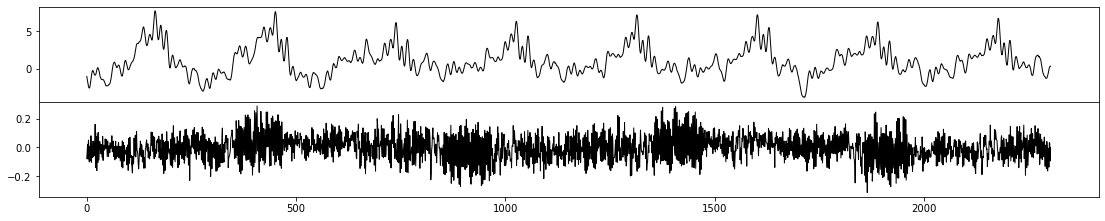

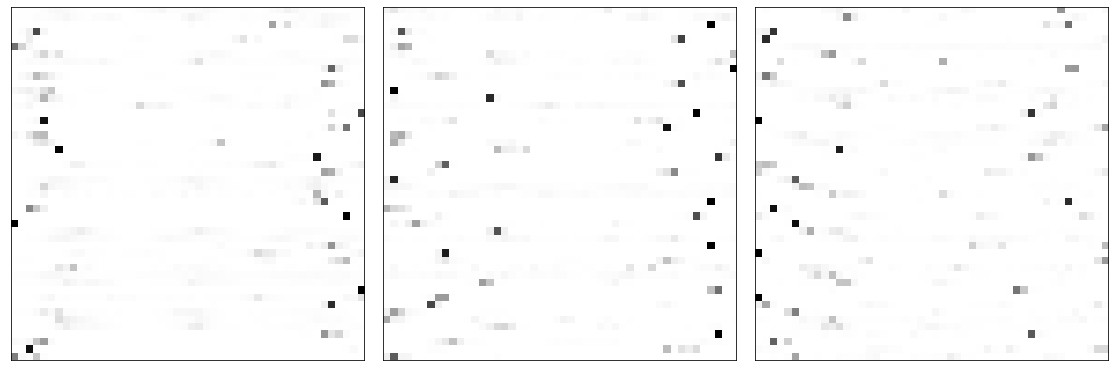

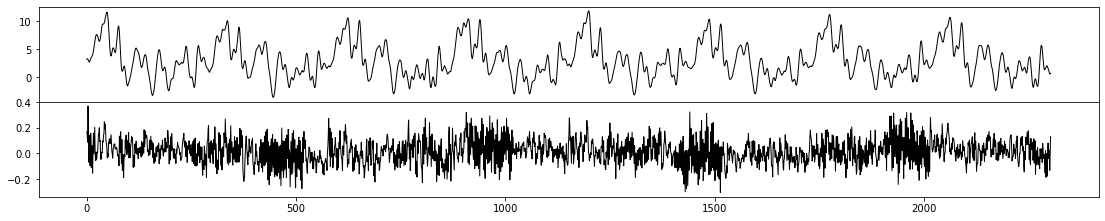

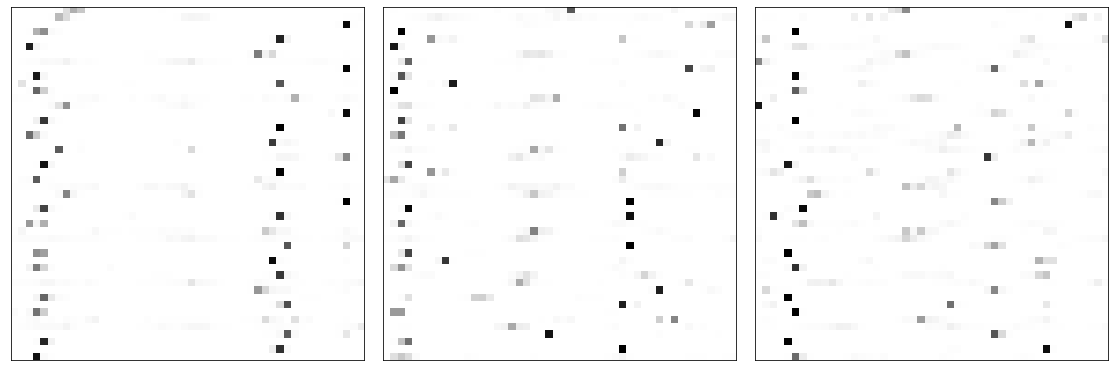

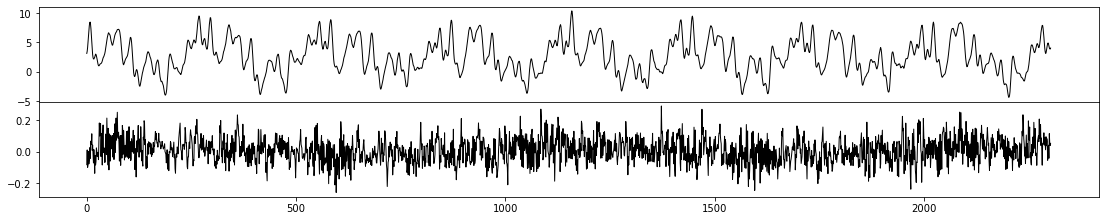

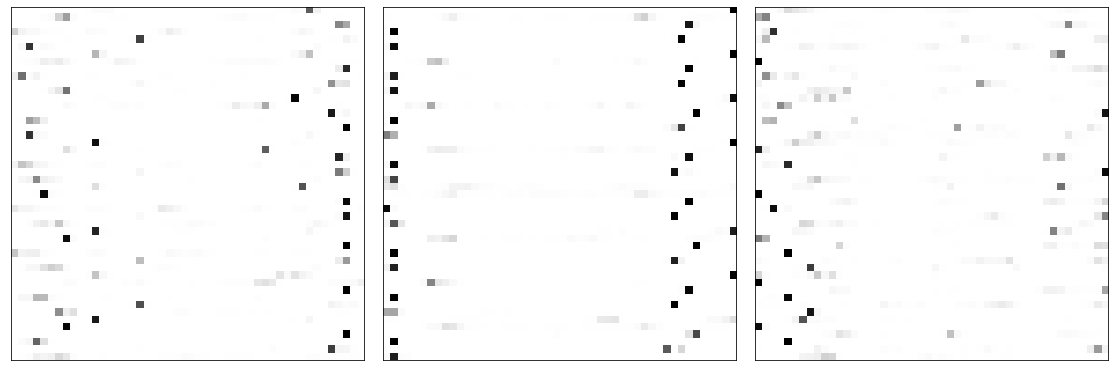

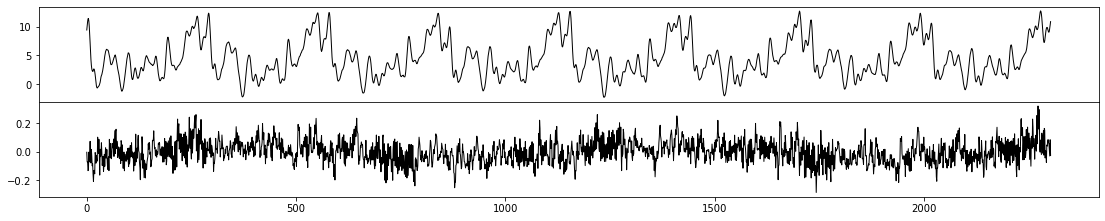

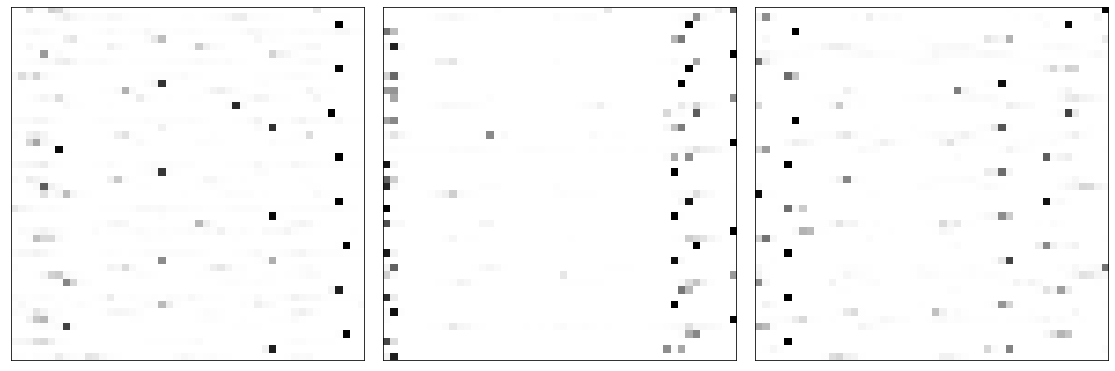

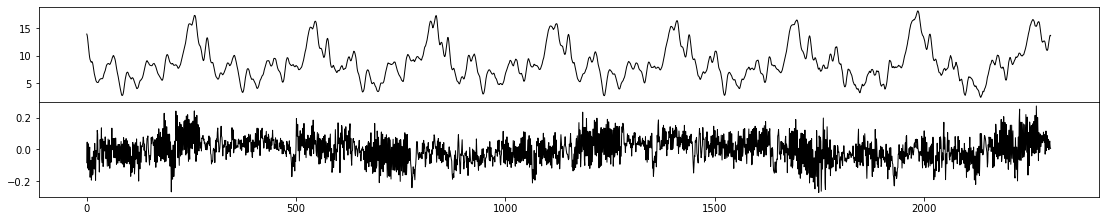

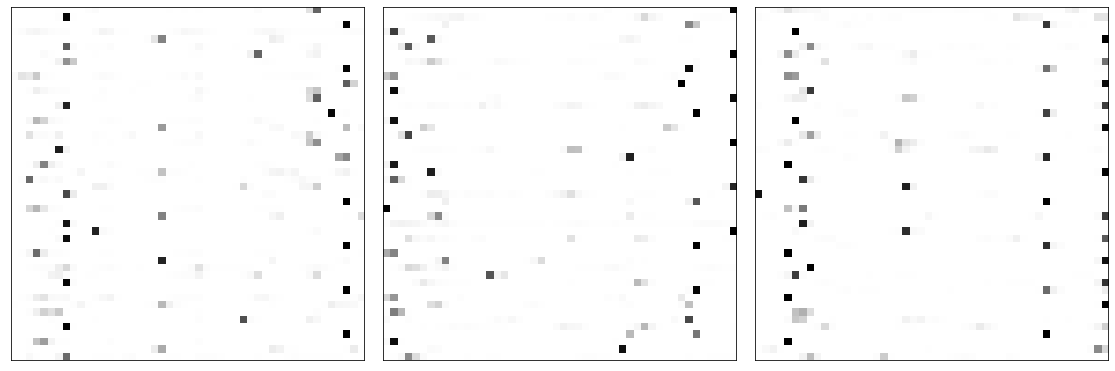

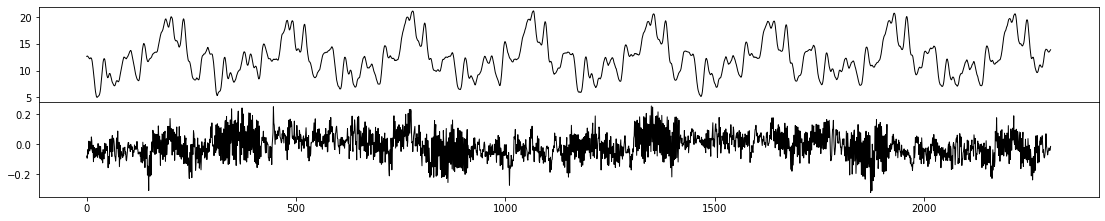

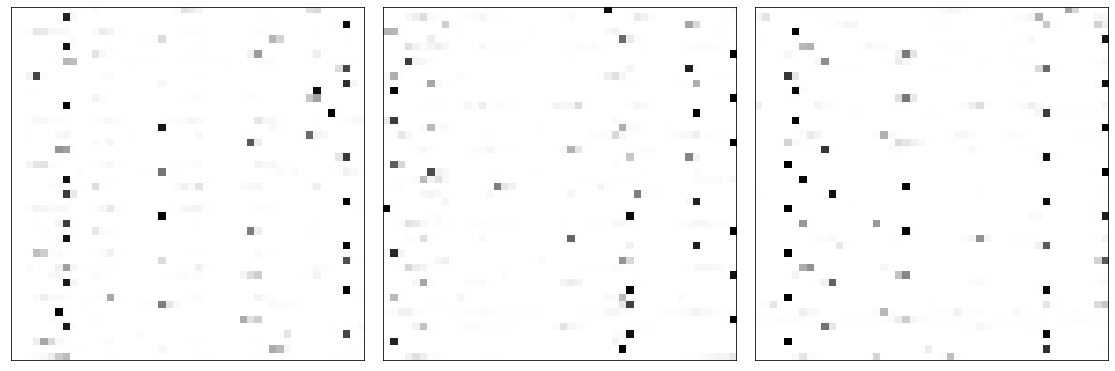

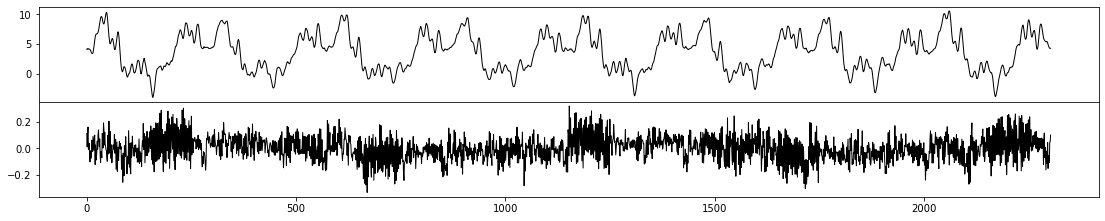

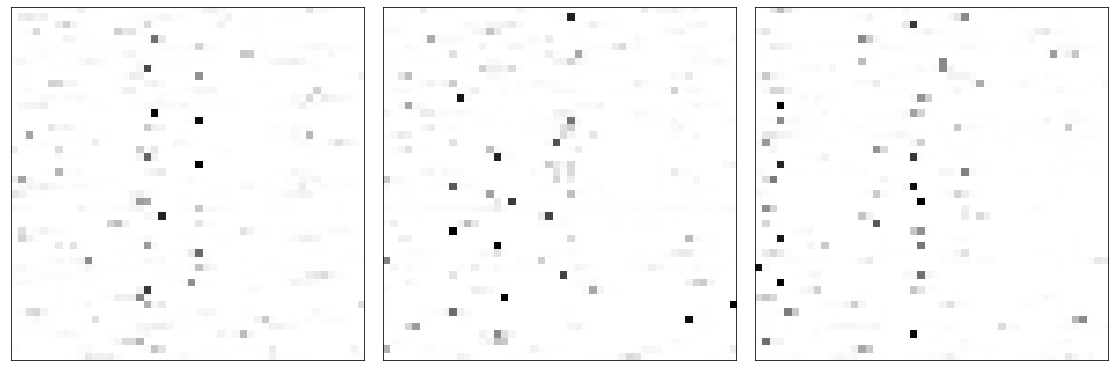

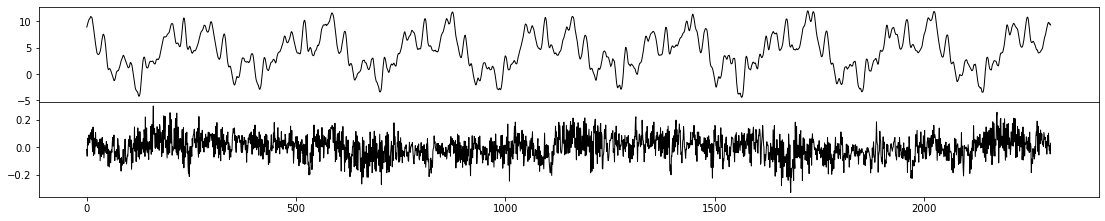

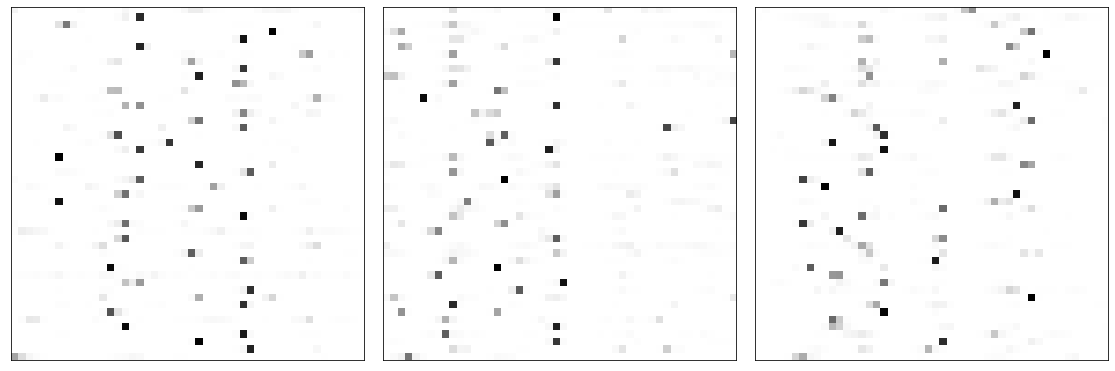

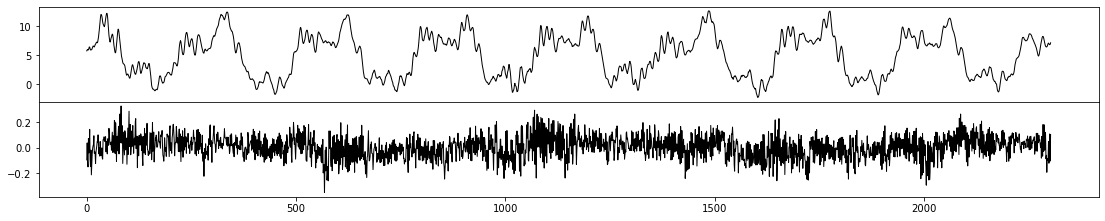

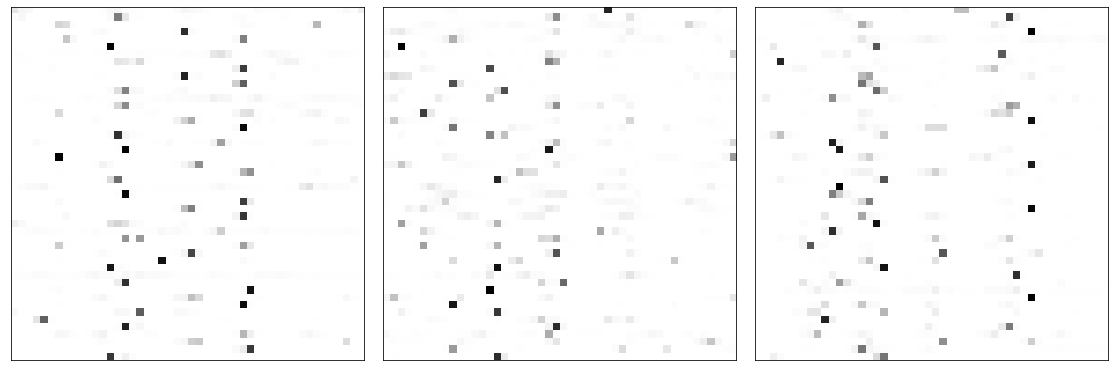

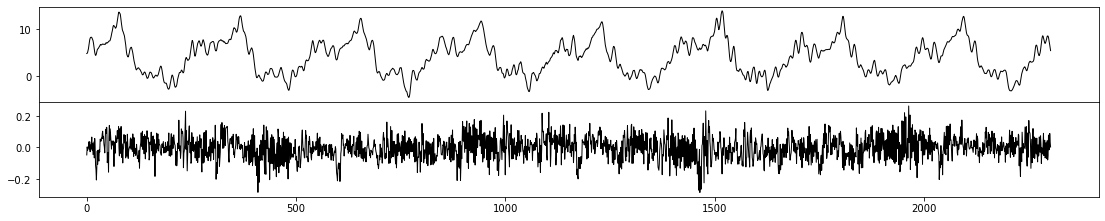

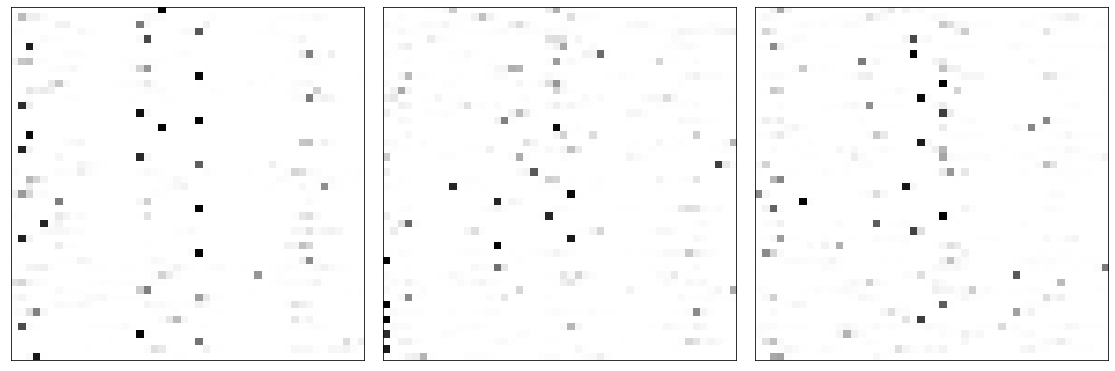

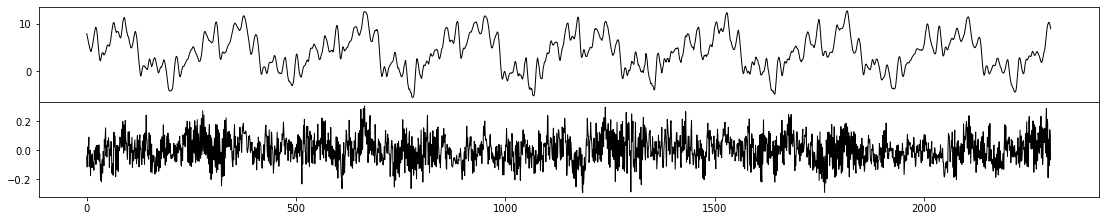

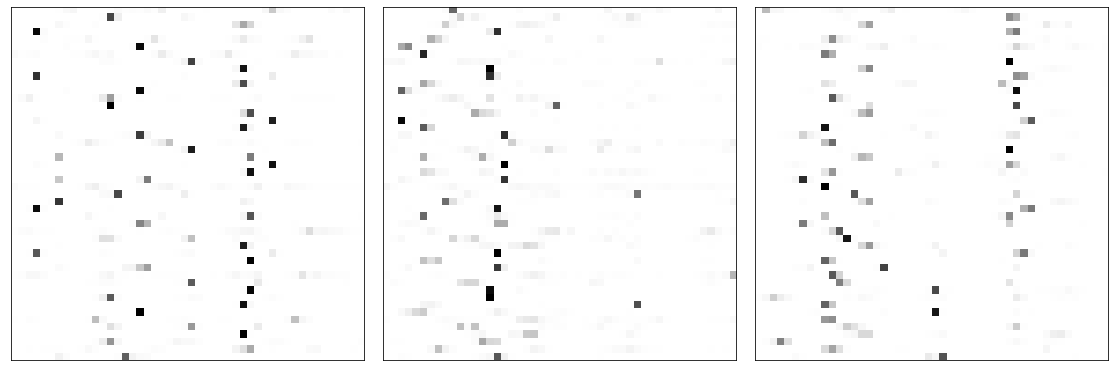

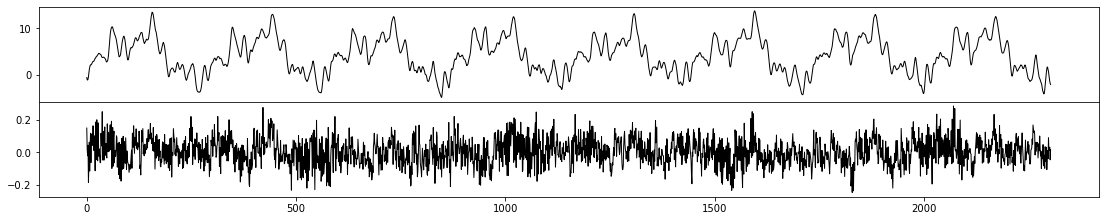

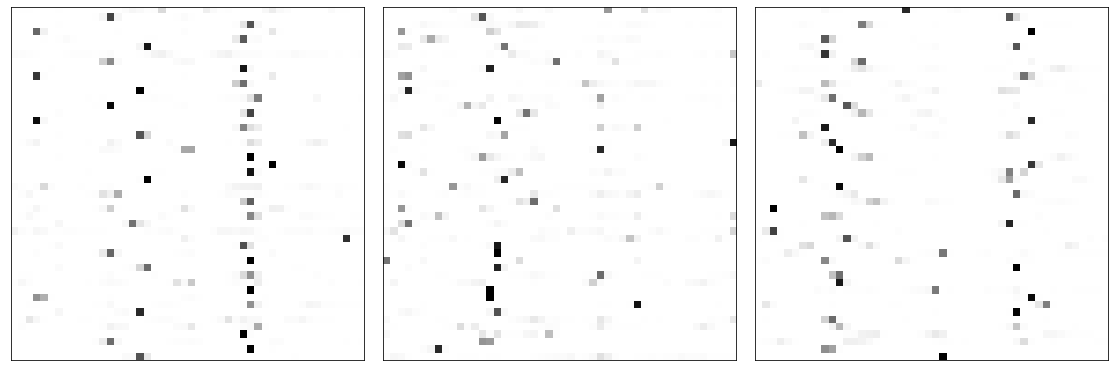

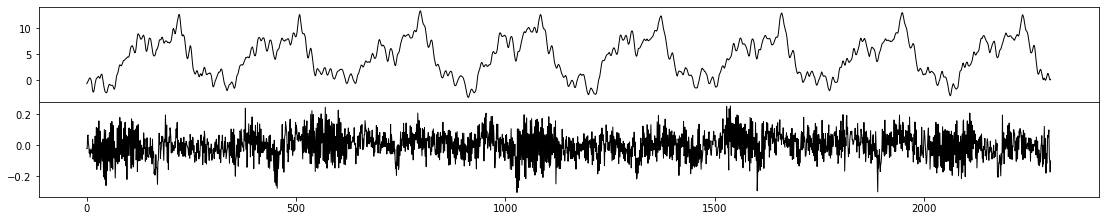

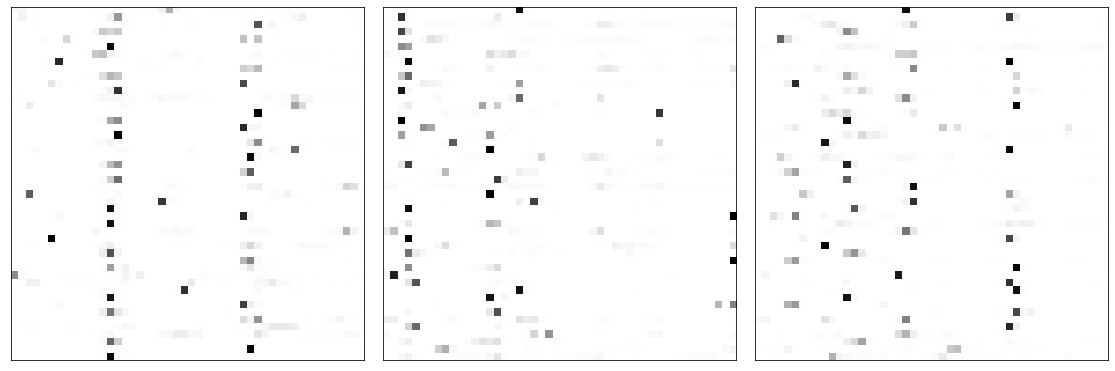

In [3]:
#注意力权重显示
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from matplotlib.patches import Rectangle


HIGHFREQ_INPUT_SIZE = [2304, 6]
LOWFREQ_INPUT_SIZE = [288, 7]
ATTENTION_RANGE = 48
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
sample_list = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]

TESTDATA_1_LOADPATH = 'tool_wear_data_7/test_data1.npy' #验证集数据1读取路径
TESTDATA_2_LOADPATH = 'tool_wear_data_7/test_data2.npy' #验证集数据2读取路径

ATT_LOCAL_1_LOADPATH = 'attention_distribution_dataset9/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_1_LOADPATH = 'attention_distribution_dataset9/attention_lowhigh_1.npy'
ATT_DETAIL_1_LOADPATH = 'attention_distribution_dataset9/attention_detail_1.npy'
ATT_LOCAL_2_LOADPATH = 'attention_distribution_dataset9/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_2_LOADPATH = 'attention_distribution_dataset9/attention_lowhigh_2.npy'
ATT_DETAIL_2_LOADPATH = 'attention_distribution_dataset9/attention_detail_2.npy'

# ATT_LOCAL_3_LOADPATH = 'attention_distribution_dataset8/attention_local_1.npy'#验证集注意力3读取路径
# ATT_LOWHIGH_3_LOADPATH = 'attention_distribution_dataset8/attention_lowhigh_1.npy'
# ATT_DETAIL_3_LOADPATH = 'attention_distribution_dataset8/attention_detail_1.npy'
# ATT_LOCAL_4_LOADPATH = 'attention_distribution_dataset8/attention_local_2.npy'#验证集注意力4读取路径
# ATT_LOWHIGH_4_LOADPATH = 'attention_distribution_dataset8/attention_lowhigh_2.npy'
# ATT_DETAIL_4_LOADPATH = 'attention_distribution_dataset8/attention_detail_2.npy'

ATT_LOCAL_3_LOADPATH = 'attention_distribution_dataset10/attention_local_1.npy'#验证集注意力3读取路径
ATT_LOWHIGH_3_LOADPATH = 'attention_distribution_dataset10/attention_lowhigh_1.npy'
ATT_DETAIL_3_LOADPATH = 'attention_distribution_dataset10/attention_detail_1.npy'
ATT_LOCAL_4_LOADPATH = 'attention_distribution_dataset10/attention_local_2.npy'#验证集注意力4读取路径
ATT_LOWHIGH_4_LOADPATH = 'attention_distribution_dataset10/attention_lowhigh_2.npy'
ATT_DETAIL_4_LOADPATH = 'attention_distribution_dataset10/attention_detail_2.npy'

ATT_LOCAL_5_LOADPATH = 'attention_distribution_dataset11/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_5_LOADPATH = 'attention_distribution_dataset11/attention_lowhigh_1.npy'
ATT_DETAIL_5_LOADPATH = 'attention_distribution_dataset11/attention_detail_1.npy'
ATT_LOCAL_6_LOADPATH = 'attention_distribution_dataset11/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_6_LOADPATH = 'attention_distribution_dataset11/attention_lowhigh_2.npy'
ATT_DETAIL_6_LOADPATH = 'attention_distribution_dataset11/attention_detail_2.npy'

ATT_DIFF_SAVEPATH = 'attention_distribution_dataset10/attention_translation_differnece.png'
SIG_SAVEPATH = 'attention_distribution_dataset10/translated_signal.png'

for sample_index in sample_list:
    sample_index +=2
    X_test = np.load(TESTDATA_1_LOADPATH)[sample_index]

    att_local_1 = np.load(ATT_LOCAL_1_LOADPATH)[sample_index]
    att_lowhigh_1 = np.load(ATT_LOWHIGH_1_LOADPATH)[sample_index]
    att_detail_1 = np.load(ATT_DETAIL_1_LOADPATH)[sample_index]

    att_local_3 = np.load(ATT_LOCAL_3_LOADPATH)[sample_index]
    att_lowhigh_3 = np.load(ATT_LOWHIGH_3_LOADPATH)[sample_index]
    att_detail_3 = np.load(ATT_DETAIL_3_LOADPATH)[sample_index]

    att_local_5 = np.load(ATT_LOCAL_5_LOADPATH)[sample_index]
    att_lowhigh_5 = np.load(ATT_LOWHIGH_5_LOADPATH)[sample_index]
    att_detail_5 = np.load(ATT_DETAIL_5_LOADPATH)[sample_index]


    fig_x = 19
    fig_y = 3.5
    plt.figure(figsize=(fig_x, fig_y))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, np.shape(X_test)[0])
    plt.subplot(2, 1, 1)
    plt.plot(X_test[:, 0], lw=1, color='black')
    plt.subplot(2, 1, 2)
    plt.plot(X_test[:, 3], lw=1, color='black')
    plt.savefig(SIG_SAVEPATH, dpi = 300, bbox_inches='tight')
    plt.show()


    fig_x = 20
    fig_y = 13
    plt.figure(figsize=(fig_x, fig_y))
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.subplot(2, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(att_lowhigh_1.reshape([48,48]), cmap='Greys')
    plt.subplot(2, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(att_lowhigh_3.reshape([48,48]), cmap='Greys')
    plt.subplot(2, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(att_lowhigh_5.reshape([48,48]), cmap='Greys')

    plt.savefig(ATT_DIFF_SAVEPATH, dpi = 300, bbox_inches='tight')
    plt.show()

X_test (2592,)


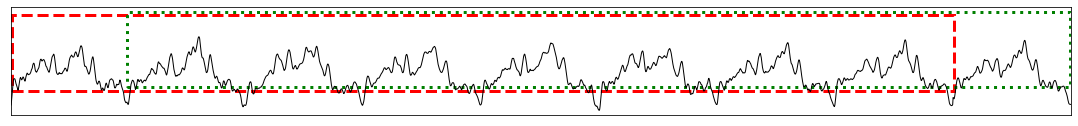

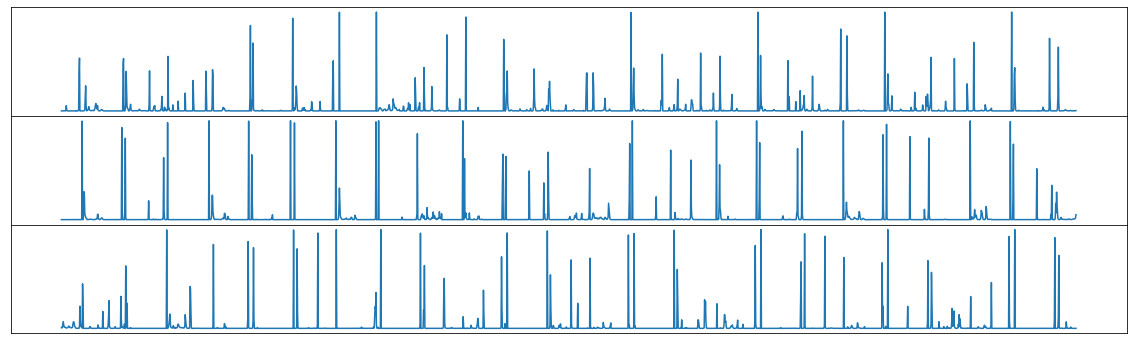

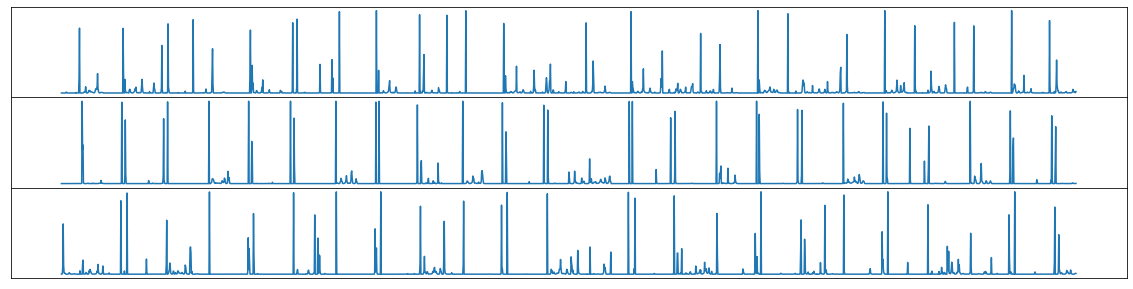

<Figure size 432x288 with 0 Axes>

X_test (2592,)


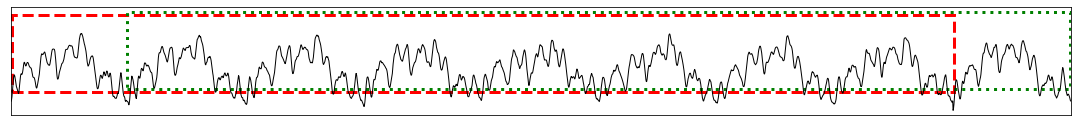

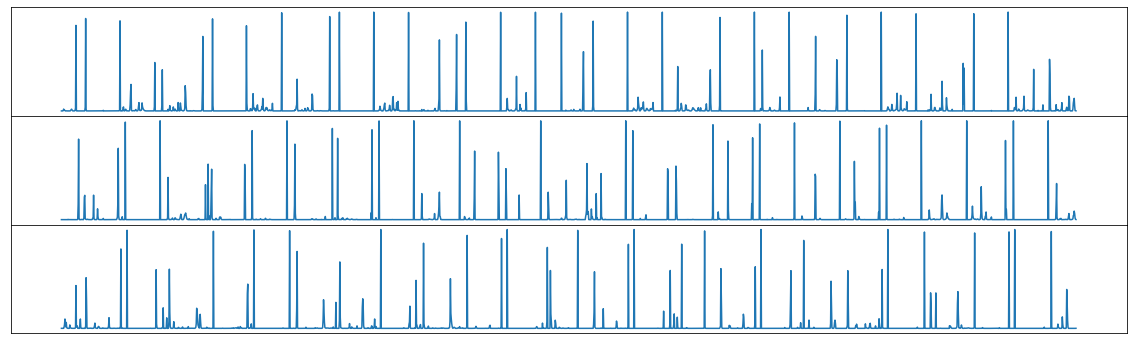

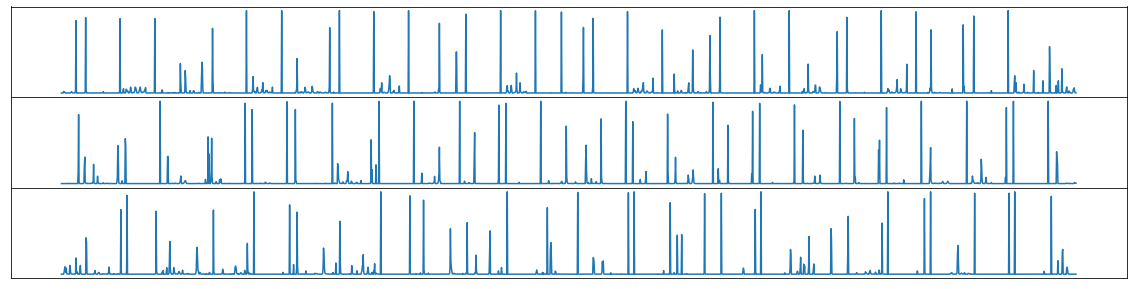

<Figure size 432x288 with 0 Axes>

X_test (2592,)


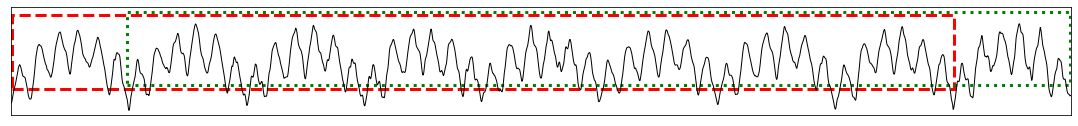

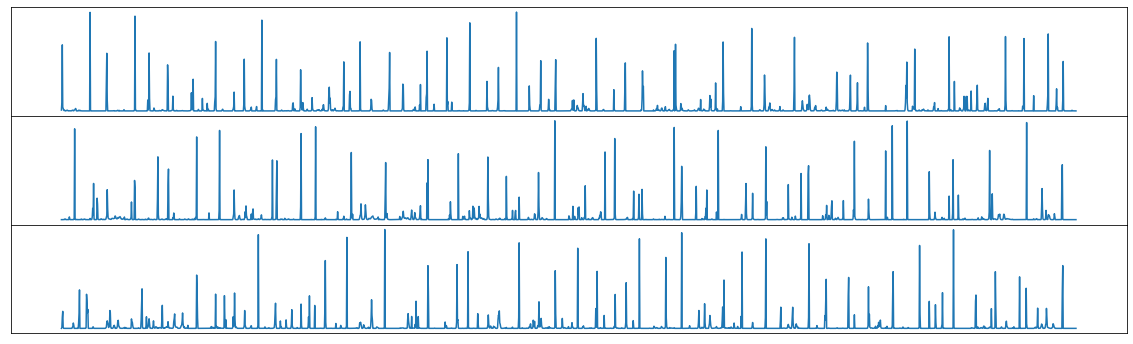

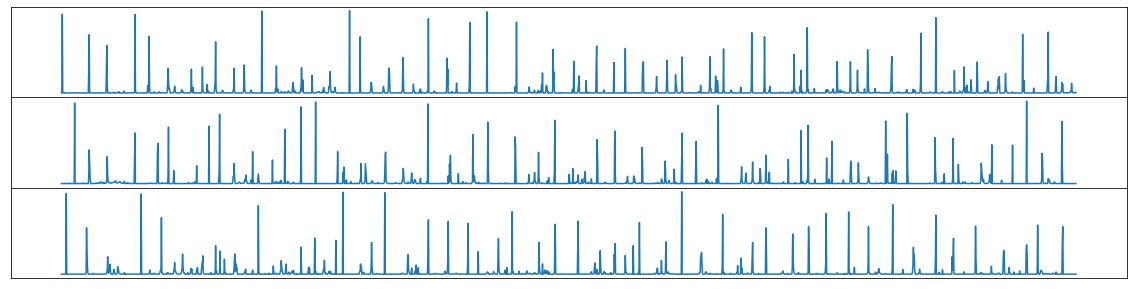

<Figure size 432x288 with 0 Axes>

X_test (2592,)


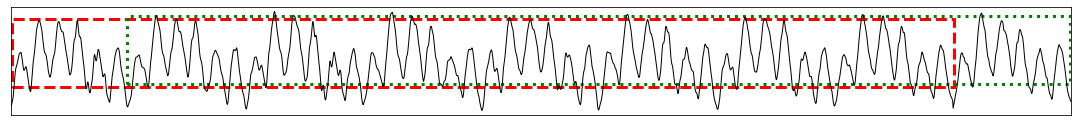

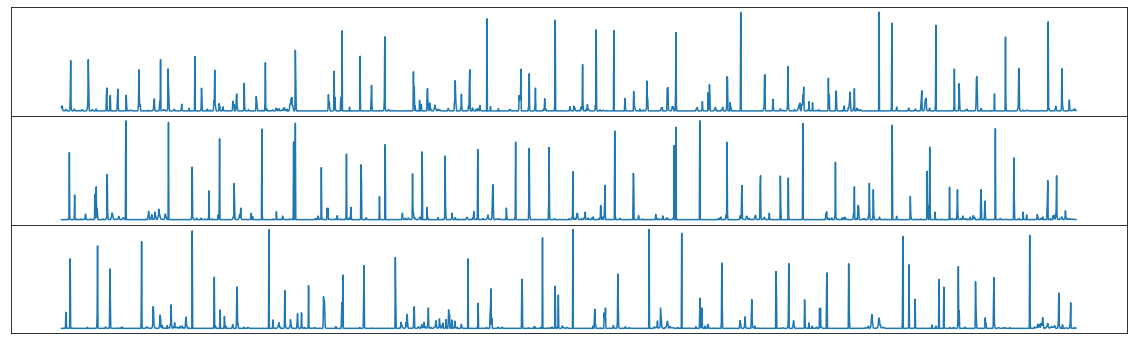

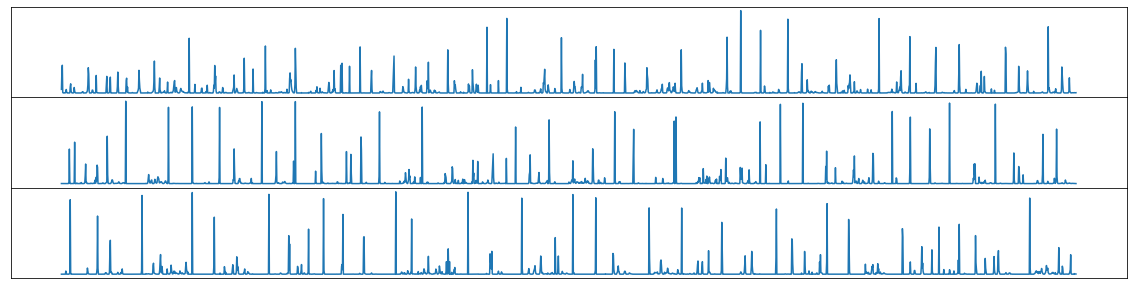

<Figure size 432x288 with 0 Axes>

X_test (2592,)


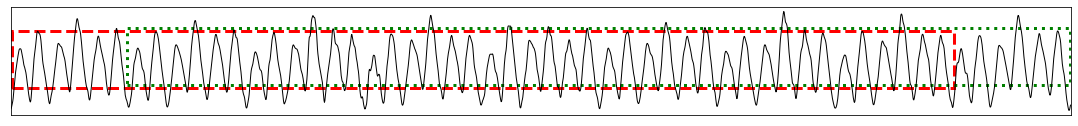

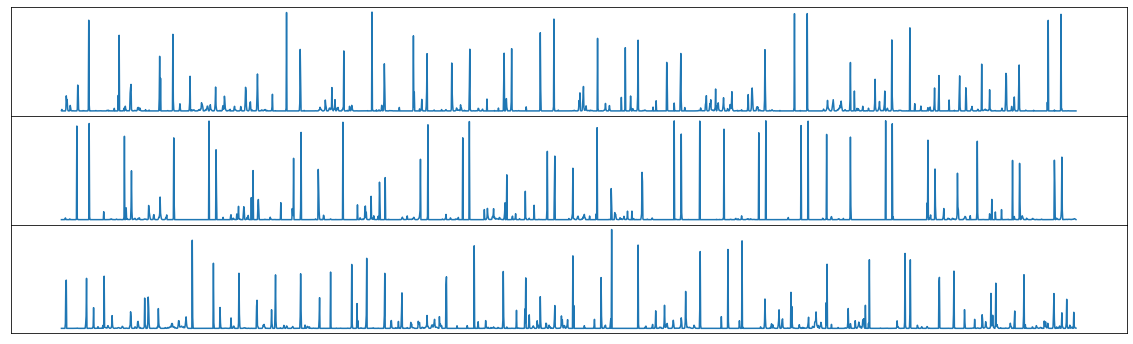

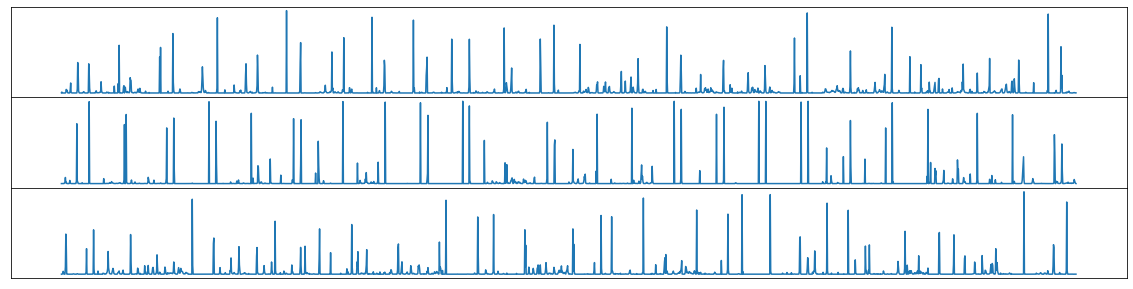

<Figure size 432x288 with 0 Axes>

X_test (2592,)


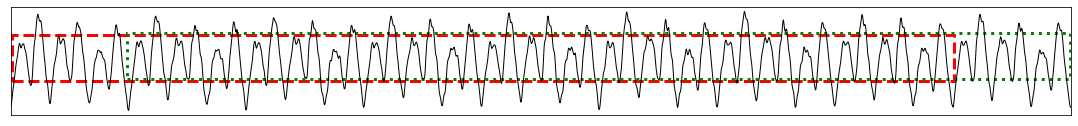

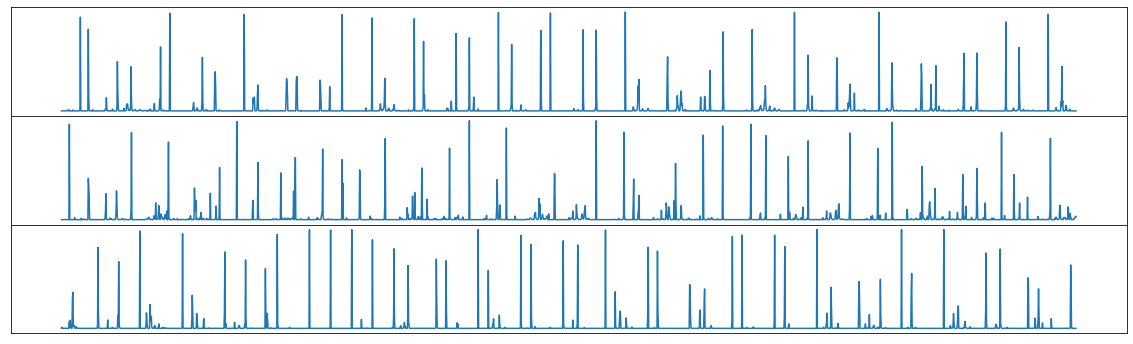

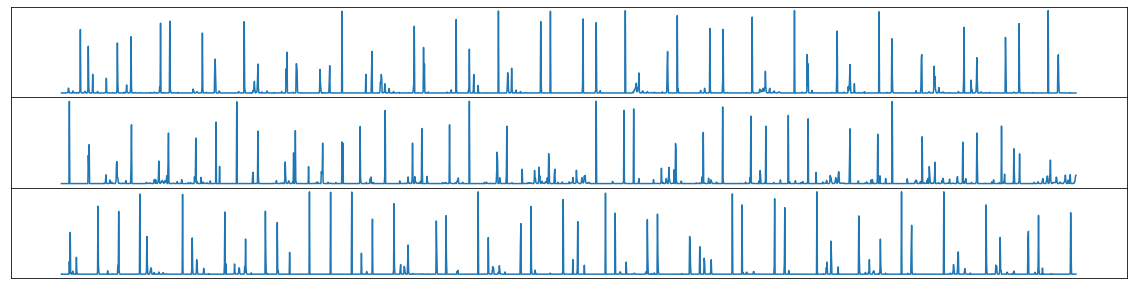

<Figure size 432x288 with 0 Axes>

X_test (2592,)


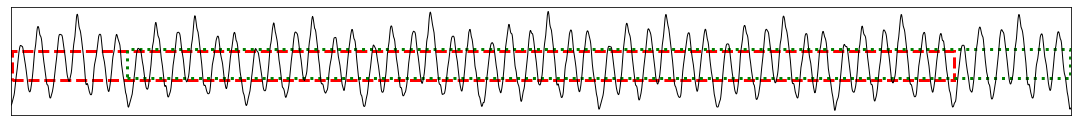

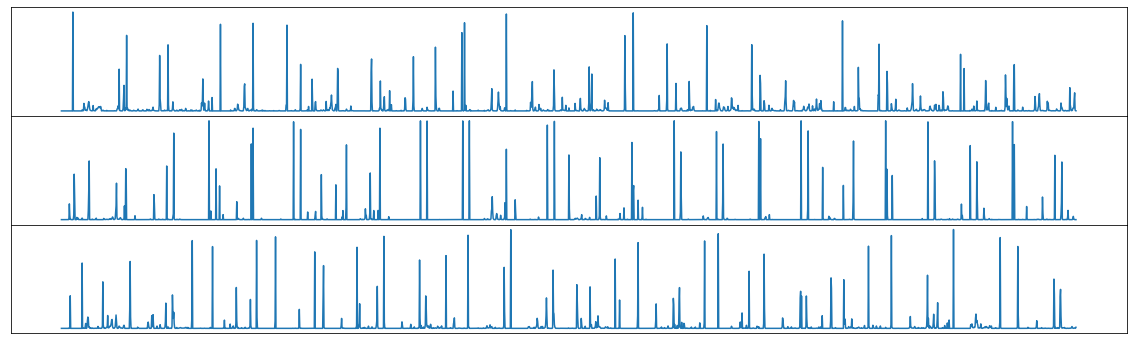

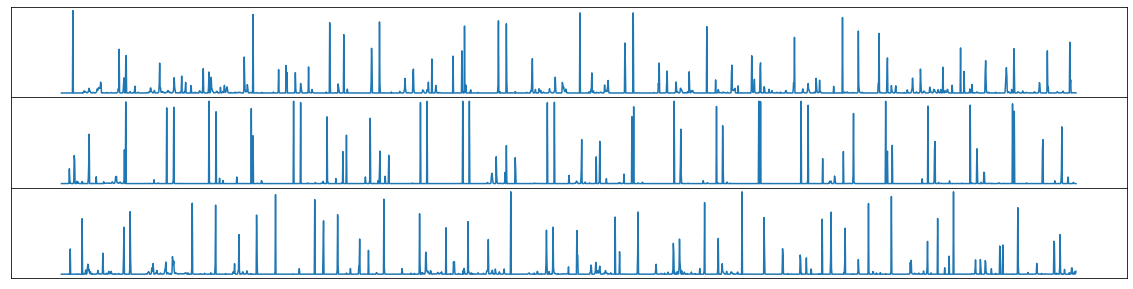

<Figure size 432x288 with 0 Axes>

X_test (2592,)


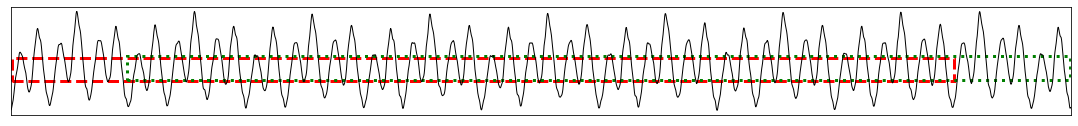

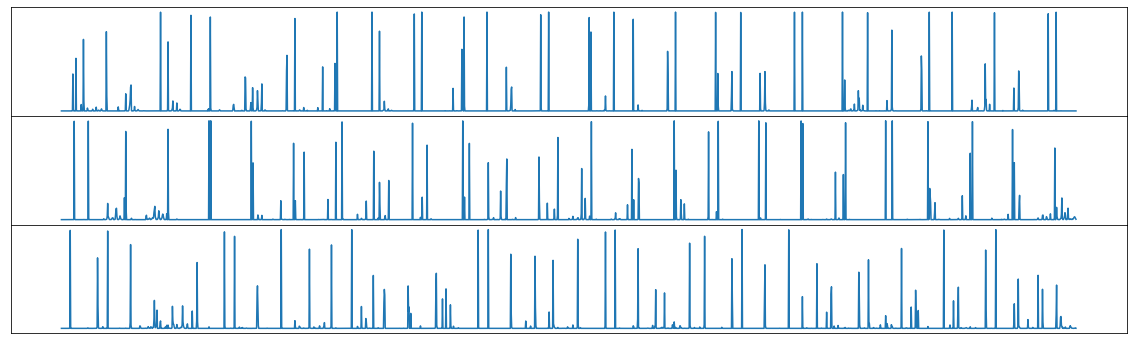

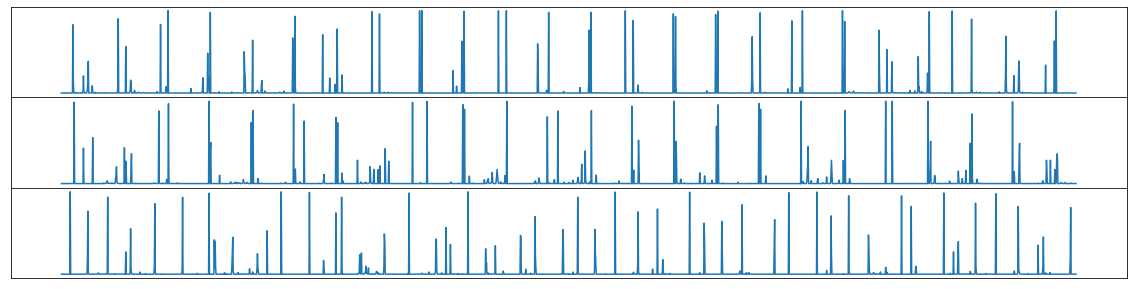

<Figure size 432x288 with 0 Axes>

X_test (2592,)


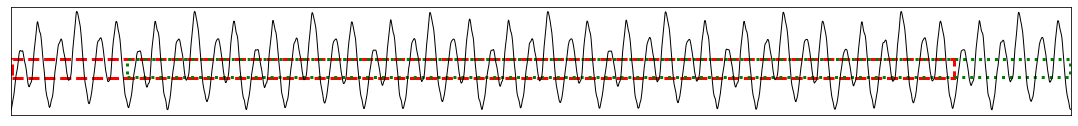

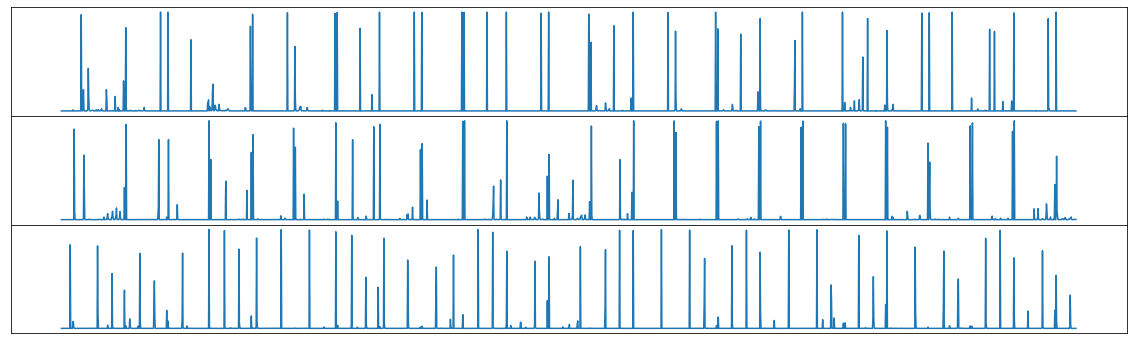

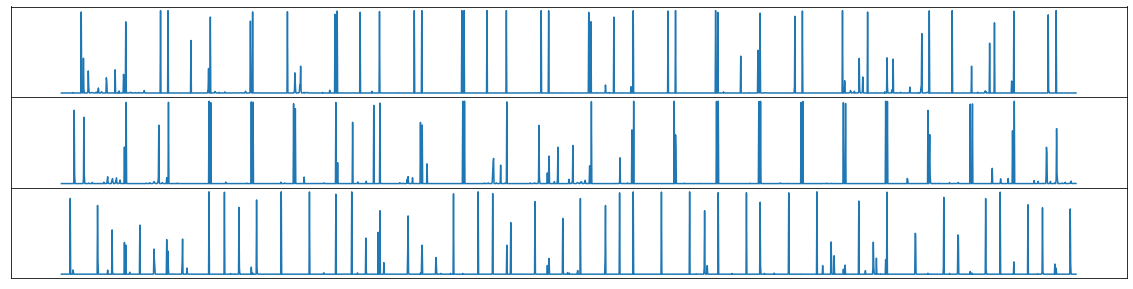

<Figure size 432x288 with 0 Axes>

X_test (2592,)


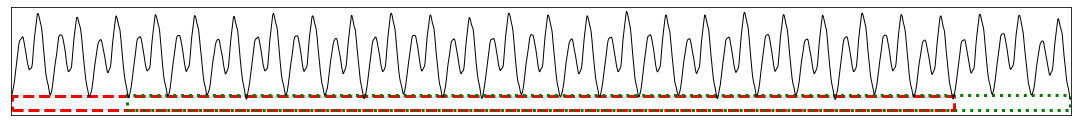

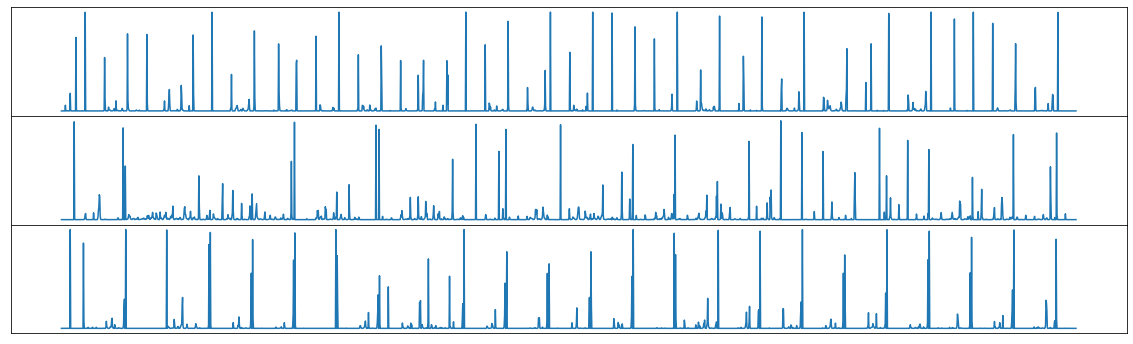

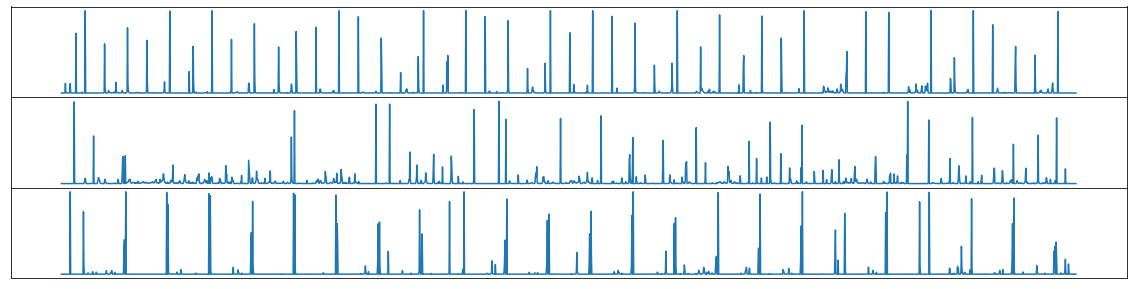

<Figure size 432x288 with 0 Axes>

In [4]:
#注意力权重显示
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from matplotlib.patches import Rectangle


HIGHFREQ_INPUT_SIZE = [2304, 6]
LOWFREQ_INPUT_SIZE = [288, 7]
ATTENTION_RANGE = 48
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
sample_list = [150, 250, 350, 450, 550, 650, 750, 850, 950, 1050]

TESTDATA_1_LOADPATH = 'tool_wear_data_8/test_data1.npy' #验证集数据1读取路径
TESTDATA_2_LOADPATH = 'tool_wear_data_8/test_data2.npy' #验证集数据2读取路径

ATT_LOCAL_1_LOADPATH = 'attention_distribution_dataset9/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_1_LOADPATH = 'attention_distribution_dataset9/attention_lowhigh_1.npy'
ATT_DETAIL_1_LOADPATH = 'attention_distribution_dataset9/attention_detail_1.npy'
ATT_LOCAL_2_LOADPATH = 'attention_distribution_dataset9/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_2_LOADPATH = 'attention_distribution_dataset9/attention_lowhigh_2.npy'
ATT_DETAIL_2_LOADPATH = 'attention_distribution_dataset9/attention_detail_2.npy'

ATT_LOCAL_3_LOADPATH = 'attention_distribution_dataset10/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_3_LOADPATH = 'attention_distribution_dataset10/attention_lowhigh_1.npy'
ATT_DETAIL_3_LOADPATH = 'attention_distribution_dataset10/attention_detail_1.npy'
ATT_LOCAL_4_LOADPATH = 'attention_distribution_dataset10/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_4_LOADPATH = 'attention_distribution_dataset10/attention_lowhigh_2.npy'
ATT_DETAIL_4_LOADPATH = 'attention_distribution_dataset10/attention_detail_2.npy'

ATT_LOCAL_5_LOADPATH = 'attention_distribution_dataset11/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_5_LOADPATH = 'attention_distribution_dataset11/attention_lowhigh_1.npy'
ATT_DETAIL_5_LOADPATH = 'attention_distribution_dataset11/attention_detail_1.npy'
ATT_LOCAL_6_LOADPATH = 'attention_distribution_dataset11/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_6_LOADPATH = 'attention_distribution_dataset11/attention_lowhigh_2.npy'
ATT_DETAIL_6_LOADPATH = 'attention_distribution_dataset11/attention_detail_2.npy'

ATT_DIFF_SAVEPATH = 'attention_distribution_dataset10/attention_translation_differnece.png'
SIG_SAVEPATH = 'attention_distribution_dataset10/translated_signal.png'

for sample_index in sample_list:
    sample_index +=31
    X_test_1 = np.load(TESTDATA_1_LOADPATH)[sample_index, :, 0]
    X_test_2 = np.load(TESTDATA_2_LOADPATH)[sample_index, :, 0]
    X_test = np.concatenate([X_test_1, X_test_2[-288:]])
    print('X_test', np.shape(X_test))

    att_local_1 = np.load(ATT_LOCAL_1_LOADPATH)[sample_index]
    att_lowhigh_1 = np.load(ATT_LOWHIGH_1_LOADPATH)[sample_index]
    att_detail_1 = np.load(ATT_DETAIL_1_LOADPATH)[sample_index]
    att_local_2 = np.load(ATT_LOCAL_2_LOADPATH)[sample_index]
    att_lowhigh_2 = np.load(ATT_LOWHIGH_2_LOADPATH)[sample_index]
    att_detail_2 = np.load(ATT_DETAIL_2_LOADPATH)[sample_index]

    att_local_3 = np.load(ATT_LOCAL_3_LOADPATH)[sample_index]
    att_lowhigh_3 = np.load(ATT_LOWHIGH_3_LOADPATH)[sample_index]
    att_detail_3 = np.load(ATT_DETAIL_3_LOADPATH)[sample_index]
    att_local_4 = np.load(ATT_LOCAL_4_LOADPATH)[sample_index]
    att_lowhigh_4 = np.load(ATT_LOWHIGH_4_LOADPATH)[sample_index]
    att_detail_4 = np.load(ATT_DETAIL_4_LOADPATH)[sample_index]

    att_local_5 = np.load(ATT_LOCAL_5_LOADPATH)[sample_index]
    att_lowhigh_5 = np.load(ATT_LOWHIGH_5_LOADPATH)[sample_index]
    att_detail_5 = np.load(ATT_DETAIL_5_LOADPATH)[sample_index]
    att_local_6 = np.load(ATT_LOCAL_6_LOADPATH)[sample_index]
    att_lowhigh_6 = np.load(ATT_LOWHIGH_6_LOADPATH)[sample_index]
    att_detail_6 = np.load(ATT_DETAIL_6_LOADPATH)[sample_index]


    fig_x = 19
    fig_y = 2
    plt.figure(figsize=(fig_x, fig_y))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xticks([])
    plt.yticks([])
    plt.gca().add_patch(Rectangle((3, -0.5), 2304, 20, fill=None, lw=3, ls='--', edgecolor="red"))
    plt.gca().add_patch(Rectangle((285, 0.5), 2304, 20, fill=None, lw=3, ls=':', edgecolor="green"))
    plt.xlim(0, np.shape(X_test)[0])
    plt.plot(X_test, lw=1, color='black')
    plt.savefig(SIG_SAVEPATH, dpi = 300, bbox_inches='tight')
    plt.show()


    fig_x = 20
    fig_y = 6
    plt.figure(figsize=(fig_x, fig_y))
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.subplot(3, 1, 1)
    plt.xticks([])
    plt.yticks([])
    plt.plot(att_lowhigh_1)
    plt.subplot(3, 1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.plot(att_lowhigh_3)
    plt.subplot(3, 1, 3)
    plt.xticks([])
    plt.yticks([])
    plt.plot(att_lowhigh_5)
    plt.show()
    
    fig_x = 20
    fig_y = 5
    plt.figure(figsize=(fig_x, fig_y))
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.subplot(3, 1, 1)
    plt.xticks([])
    plt.yticks([])
    plt.plot(att_lowhigh_2)
    plt.subplot(3, 1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.plot(att_lowhigh_4)
    plt.subplot(3, 1, 3)
    plt.xticks([])
    plt.yticks([])
    plt.plot(att_lowhigh_6)
    plt.show()

    plt.savefig(ATT_DIFF_SAVEPATH, dpi = 300, bbox_inches='tight')
    plt.show()

## 相似度比较

### 时域相似度比较

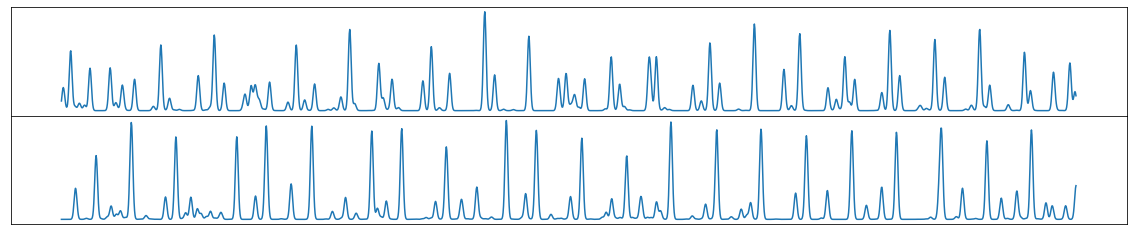

0.5844222657817235


In [9]:
#注意力权重显示
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from matplotlib.patches import Rectangle
from sklearn.metrics.pairwise import cosine_similarity



HIGHFREQ_INPUT_SIZE = [2304, 6]
LOWFREQ_INPUT_SIZE = [288, 7]
ATTENTION_RANGE = 48
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])

TESTDATA_1_LOADPATH = 'tool_wear_data_8/test_data1.npy' #验证集数据1读取路径
TESTDATA_2_LOADPATH = 'tool_wear_data_8/test_data2.npy' #验证集数据2读取路径

ATT_LOCAL_1_LOADPATH = 'attention_distribution_dataset9/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_1_LOADPATH = 'attention_distribution_dataset9/attention_lowhigh_1.npy'
ATT_DETAIL_1_LOADPATH = 'attention_distribution_dataset9/attention_detail_1.npy'
ATT_LOCAL_2_LOADPATH = 'attention_distribution_dataset9/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_2_LOADPATH = 'attention_distribution_dataset9/attention_lowhigh_2.npy'
ATT_DETAIL_2_LOADPATH = 'attention_distribution_dataset9/attention_detail_2.npy'

ATT_LOCAL_3_LOADPATH = 'attention_distribution_dataset10/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_3_LOADPATH = 'attention_distribution_dataset10/attention_lowhigh_1.npy'
ATT_DETAIL_3_LOADPATH = 'attention_distribution_dataset10/attention_detail_1.npy'
ATT_LOCAL_4_LOADPATH = 'attention_distribution_dataset10/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_4_LOADPATH = 'attention_distribution_dataset10/attention_lowhigh_2.npy'
ATT_DETAIL_4_LOADPATH = 'attention_distribution_dataset10/attention_detail_2.npy'

ATT_LOCAL_5_LOADPATH = 'attention_distribution_dataset11/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_5_LOADPATH = 'attention_distribution_dataset11/attention_lowhigh_1.npy'
ATT_DETAIL_5_LOADPATH = 'attention_distribution_dataset11/attention_detail_1.npy'
ATT_LOCAL_6_LOADPATH = 'attention_distribution_dataset11/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_6_LOADPATH = 'attention_distribution_dataset11/attention_lowhigh_2.npy'
ATT_DETAIL_6_LOADPATH = 'attention_distribution_dataset11/attention_detail_2.npy'

ATT_DIFF_SAVEPATH = 'attention_distribution_dataset9/attention_translation_differnece.png'
SIG_SAVEPATH = 'attention_distribution_dataset9/translated_signal.png'

acceptable_bias = 140

def gaussian_filtering(input_x, variation=3, filter_length=80):   #一维高斯滤波，输入方差、滤波器长度和输入
    filter_x = np.array(np.arange(-filter_length/2, filter_length/2))
    gauss_filter = np.exp(-pow(filter_x, 2)/(2*pow(variation, 2)))/(variation*np.sqrt(2*np.pi))
    gauss_filter = gauss_filter/np.sum(gauss_filter)
    filted_signal = np.convolve(input_x, gauss_filter, mode='same')
    return filted_signal

att_detail_1 = np.load(ATT_DETAIL_1_LOADPATH)
att_detail_3 = np.load(ATT_DETAIL_3_LOADPATH)

coco_matrix = np.zeros([int(np.shape(att_detail_1)[0]/30+1), acceptable_bias*2]) #Correlation coefficient， 一行一样本，一列一偏移
for i in range(0, np.shape(att_detail_1)[0], 30):
#     print('i', i)
    for j in range(-acceptable_bias, acceptable_bias):
        if j > 0:
            att_sample_1 = gaussian_filtering(att_detail_1[i, j:])
            att_sample_3 = gaussian_filtering(att_detail_3[i, :-j])            
        elif j < 0:
            att_sample_1 = gaussian_filtering(att_detail_1[i, :j])
            att_sample_3 = gaussian_filtering(att_detail_3[i, -j:])
        else:
            att_sample_1 = gaussian_filtering(att_detail_1[i])
            att_sample_3 = gaussian_filtering(att_detail_3[i])
        coco_matrix[int(i/30), j+acceptable_bias] = cosine_similarity([att_sample_1, att_sample_3])[0, 1]

        
fig_x = 20
fig_y = 4
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(2, 1, 1)
plt.xticks([])
plt.yticks([])
plt.plot(att_sample_1)
plt.subplot(2, 1, 2)
plt.xticks([])
plt.yticks([])
plt.plot(att_sample_3)
plt.show()
            
coco = np.max(coco_matrix, axis = 1)
# print(coco)
print(np.mean(coco))


### 频域相似度比较

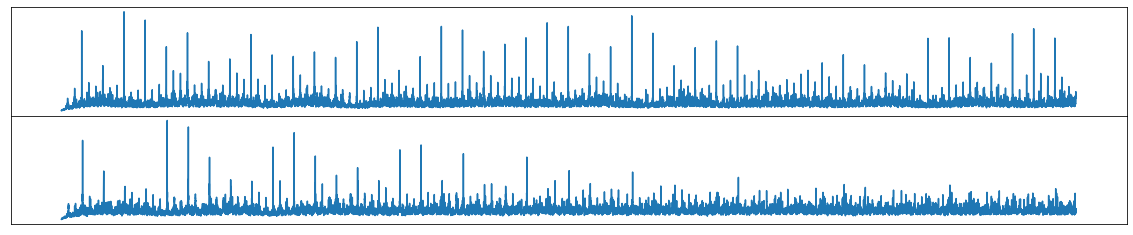

0.9515279112145262


In [12]:
#注意力权重显示
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from matplotlib.patches import Rectangle
from sklearn.metrics.pairwise import cosine_similarity
import time
import xlrd
import os
import numpy.fft as fft

HIGHFREQ_INPUT_SIZE = [2304, 6]
LOWFREQ_INPUT_SIZE = [288, 7]
ATTENTION_RANGE = 48
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])

TESTDATA_1_LOADPATH = 'tool_wear_data_8/test_data1.npy' #验证集数据1读取路径
TESTDATA_2_LOADPATH = 'tool_wear_data_8/test_data2.npy' #验证集数据2读取路径

ATT_LOCAL_1_LOADPATH = 'attention_distribution_dataset9/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_1_LOADPATH = 'attention_distribution_dataset9/attention_lowhigh_1.npy'
ATT_DETAIL_1_LOADPATH = 'attention_distribution_dataset9/attention_detail_1.npy'
ATT_LOCAL_2_LOADPATH = 'attention_distribution_dataset9/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_2_LOADPATH = 'attention_distribution_dataset9/attention_lowhigh_2.npy'
ATT_DETAIL_2_LOADPATH = 'attention_distribution_dataset9/attention_detail_2.npy'

ATT_LOCAL_3_LOADPATH = 'attention_distribution_dataset10/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_3_LOADPATH = 'attention_distribution_dataset10/attention_lowhigh_1.npy'
ATT_DETAIL_3_LOADPATH = 'attention_distribution_dataset10/attention_detail_1.npy'
ATT_LOCAL_4_LOADPATH = 'attention_distribution_dataset10/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_4_LOADPATH = 'attention_distribution_dataset10/attention_lowhigh_2.npy'
ATT_DETAIL_4_LOADPATH = 'attention_distribution_dataset10/attention_detail_2.npy'

ATT_LOCAL_5_LOADPATH = 'attention_distribution_dataset11/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_5_LOADPATH = 'attention_distribution_dataset11/attention_lowhigh_1.npy'
ATT_DETAIL_5_LOADPATH = 'attention_distribution_dataset11/attention_detail_1.npy'
ATT_LOCAL_6_LOADPATH = 'attention_distribution_dataset11/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_6_LOADPATH = 'attention_distribution_dataset11/attention_lowhigh_2.npy'
ATT_DETAIL_6_LOADPATH = 'attention_distribution_dataset11/attention_detail_2.npy'

ATT_DIFF_SAVEPATH = 'attention_distribution_dataset9/attention_translation_differnece.png'
SIG_SAVEPATH = 'attention_distribution_dataset9/translated_signal.png'

acceptable_bias = 100

def gaussian_filtering(input_x, variation=3, filter_length=100):   #一维高斯滤波，输入方差、滤波器长度和输入
    filter_x = np.array(np.arange(-filter_length/2, filter_length/2))
    gauss_filter = np.exp(-pow(filter_x, 2)/(2*pow(variation, 2)))/(variation*np.sqrt(2*np.pi))
    gauss_filter = gauss_filter/np.sum(gauss_filter)
#     plt.plot(gauss_filter)
#     plt.show()
    filted_signal = np.convolve(input_x, gauss_filter, mode='same')
    return filted_signal

def fourier_transform(data):
    complex_array = fft.fft(data)
    freqs = fft.fftfreq(np.shape(data)[0])# 得到分解波的频率序列
    pows = np.abs(complex_array)# 复数的模为信号的振幅（能量大小）
    pows = pows[freqs > 0]
    freqs = freqs[freqs > 0]
    x=np.arange(0,25000,25000/np.shape(pows)[0])[:np.shape(pows)[0]]
    pows = gaussian_filtering(pows, 1, 100) #gauss加窗
    return pows, x

att_detail_1 = np.load(ATT_DETAIL_5_LOADPATH)
att_detail_3 = np.load(ATT_DETAIL_2_LOADPATH)

coco_matrix = np.zeros([int(np.shape(att_detail_1)[0]/1000+1), acceptable_bias*2]) #Correlation coefficient， 一行一样本，一列一偏移
for i in range(0, np.shape(att_detail_1)[0], 1000):
#     print('i', i)
    att_fourier_1, _ = fourier_transform(att_detail_1[i:i+100].reshape([-1]))
    att_fourier_3, _ = fourier_transform(att_detail_3[i:i+100].reshape([-1]))
#     print('att_fourier_1', np.shape(att_fourier_1))
    for j in range(-acceptable_bias, acceptable_bias):
        if j > 0:
            att_sample_1 = gaussian_filtering(att_fourier_1[j:])
            att_sample_3 = gaussian_filtering(att_fourier_3[:-j])   
        elif j < 0:
            att_sample_1 = gaussian_filtering(att_fourier_1[:j])
            att_sample_3 = gaussian_filtering(att_fourier_3[-j:])
        else:
            att_sample_1 = gaussian_filtering(att_fourier_1)
            att_sample_3 = gaussian_filtering(att_fourier_3)
        coco_matrix[int(i/1000), j] = cosine_similarity([att_sample_1, att_sample_3])[0, 1]
        
fig_x = 20
fig_y = 4
plt.figure(figsize=(fig_x, fig_y))
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(2, 1, 1)
plt.xticks([])
plt.yticks([])
plt.plot(att_sample_1)
plt.subplot(2, 1, 2)
plt.xticks([])
plt.yticks([])
plt.plot(att_sample_3)
plt.show()
            
coco = np.max(coco_matrix, axis = 1)
# print(coco)
print(np.mean(coco))


## 作图

X_test (2592,)


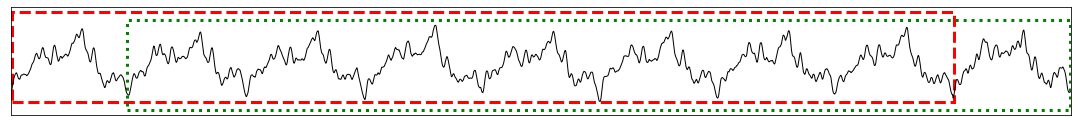

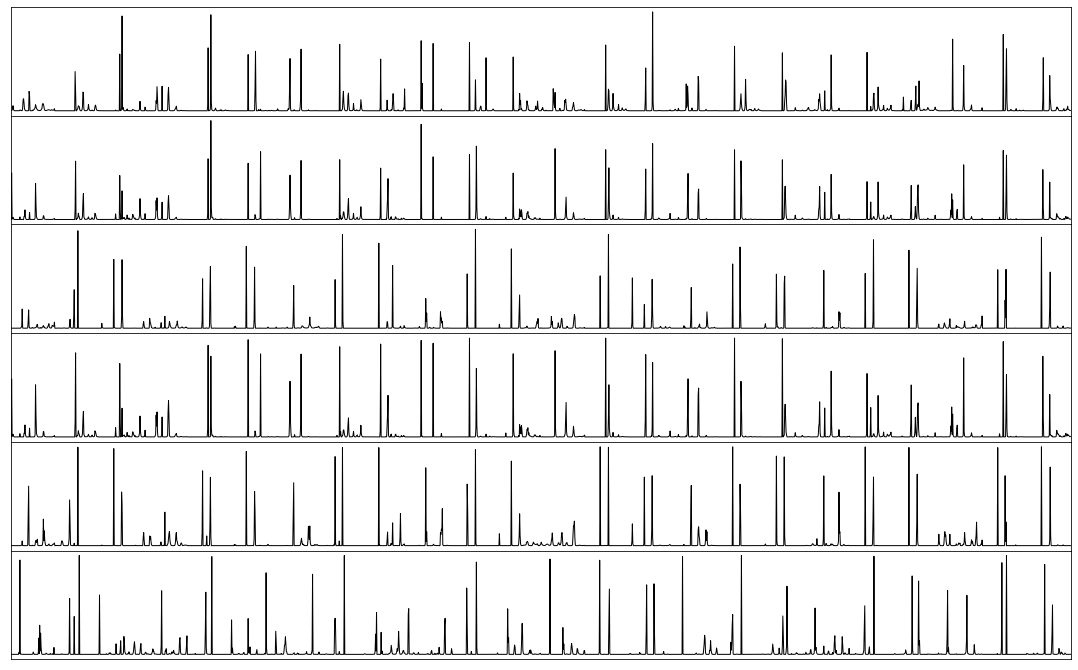

[0.61395928 0.62547086 0.6225988  0.60504506 0.57504872 0.53713362
 0.49719071 0.46117433 0.43395749 0.41836026 0.41488735 0.42199577
 0.43670981 0.45532203 0.47397987 0.48908867 0.49758139 0.49715081
 0.48651949 0.46562244 0.43572581 0.3992908  0.35954989 0.31991235
 0.28334526 0.25185967 0.22628879 0.20640768 0.19121744 0.17919364
 0.16916929 0.16046506 0.15290245 0.14668772 0.14217665 0.13959127
 0.13881259 0.13931741 0.14026954 0.14072313 0.139863   0.1373401
 0.13268594 0.12625921 0.1186191  0.10988245 0.10200505 0.09518969
 0.08998482 0.08683083 0.08595766 0.08735052 0.09072849 0.09557392
 0.10119315 0.10683459 0.11178761 0.11555731 0.11791849 0.11894244
 0.11896341 0.11848451 0.11805997 0.11820476 0.11874839 0.12151989
 0.12608992 0.1328548  0.14217156 0.15429997 0.16931036 0.18685792
 0.20625341 0.2264405  0.24613958 0.26403395 0.2789929  0.29024558
 0.29745017 0.30066453 0.30027832 0.29697877 0.29178838 0.28614911
 0.28196562 0.28152773 0.28725365 0.30127892 0.32498946 0.35862

In [8]:
#注意力权重显示
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize
from matplotlib.patches import Rectangle
from sklearn.metrics.pairwise import cosine_similarity



HIGHFREQ_INPUT_SIZE = [2304, 6]
LOWFREQ_INPUT_SIZE = [288, 7]
ATTENTION_RANGE = 48
PADDING_LENGTH = int(ATTENTION_RANGE - HIGHFREQ_INPUT_SIZE[0]/LOWFREQ_INPUT_SIZE[0])
sample_list = [150]
acceptable_bias = 140



TESTDATA_1_LOADPATH = 'tool_wear_data_8/test_data1.npy' #验证集数据1读取路径
TESTDATA_2_LOADPATH = 'tool_wear_data_8/test_data2.npy' #验证集数据2读取路径

ATT_LOCAL_1_LOADPATH = 'attention_distribution_dataset9/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_1_LOADPATH = 'attention_distribution_dataset9/attention_lowhigh_1.npy'
ATT_DETAIL_1_LOADPATH = 'attention_distribution_dataset9/attention_detail_1.npy'
ATT_LOCAL_2_LOADPATH = 'attention_distribution_dataset9/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_2_LOADPATH = 'attention_distribution_dataset9/attention_lowhigh_2.npy'
ATT_DETAIL_2_LOADPATH = 'attention_distribution_dataset9/attention_detail_2.npy'

ATT_LOCAL_3_LOADPATH = 'attention_distribution_dataset10/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_3_LOADPATH = 'attention_distribution_dataset10/attention_lowhigh_1.npy'
ATT_DETAIL_3_LOADPATH = 'attention_distribution_dataset10/attention_detail_1.npy'
ATT_LOCAL_4_LOADPATH = 'attention_distribution_dataset10/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_4_LOADPATH = 'attention_distribution_dataset10/attention_lowhigh_2.npy'
ATT_DETAIL_4_LOADPATH = 'attention_distribution_dataset10/attention_detail_2.npy'

ATT_LOCAL_5_LOADPATH = 'attention_distribution_dataset11/attention_local_1.npy'#验证集注意力1读取路径
ATT_LOWHIGH_5_LOADPATH = 'attention_distribution_dataset11/attention_lowhigh_1.npy'
ATT_DETAIL_5_LOADPATH = 'attention_distribution_dataset11/attention_detail_1.npy'
ATT_LOCAL_6_LOADPATH = 'attention_distribution_dataset11/attention_local_2.npy'#验证集注意力2读取路径
ATT_LOWHIGH_6_LOADPATH = 'attention_distribution_dataset11/attention_lowhigh_2.npy'
ATT_DETAIL_6_LOADPATH = 'attention_distribution_dataset11/attention_detail_2.npy'

ATT_DIFF_SAVEPATH = 'attention_distribution_dataset10/attention_translation_differnece.png'
SIG_SAVEPATH = 'attention_distribution_dataset10/translated_signal.png'


def gaussian_filtering(input_x, variation=3, filter_length=80):   #一维高斯滤波，输入方差、滤波器长度和输入
    filter_x = np.array(np.arange(-filter_length/2, filter_length/2))
    gauss_filter = np.exp(-pow(filter_x, 2)/(2*pow(variation, 2)))/(variation*np.sqrt(2*np.pi))
    gauss_filter = gauss_filter/np.sum(gauss_filter)
#     plt.plot(gauss_filter)
#     plt.show()
    filted_signal = np.convolve(input_x, gauss_filter, mode='same')
    return filted_signal

for sample_index in sample_list:
    X_test_1 = np.load(TESTDATA_1_LOADPATH)[sample_index, :, 0]
    X_test_2 = np.load(TESTDATA_2_LOADPATH)[sample_index, :, 0]
    X_test = np.concatenate([X_test_1, X_test_2[-288:]])
    print('X_test', np.shape(X_test))

    att_detail_1 = np.load(ATT_DETAIL_1_LOADPATH)[sample_index]
    att_detail_2 = np.load(ATT_DETAIL_2_LOADPATH)[sample_index]
    att_detail_3 = np.load(ATT_DETAIL_3_LOADPATH)[sample_index]
    att_detail_4 = np.load(ATT_DETAIL_4_LOADPATH)[sample_index]
    att_detail_5 = np.load(ATT_DETAIL_5_LOADPATH)[sample_index]
    att_detail_6 = np.load(ATT_DETAIL_6_LOADPATH)[sample_index]
    
    fig_x = 19
    fig_y = 2
    plt.figure(figsize=(fig_x, fig_y))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xticks([])
    plt.yticks([])
    plt.gca().add_patch(Rectangle((3, -5.5), 2304, 22, fill=None, lw=3, ls='--', edgecolor="red"))
    plt.gca().add_patch(Rectangle((285, -7.5), 2304, 22, fill=None, lw=3, ls=':', edgecolor="green"))
    plt.xlim(0, np.shape(X_test)[0])
    plt.plot(X_test, lw=1, color='black')
    plt.savefig(SIG_SAVEPATH, dpi = 400, bbox_inches='tight')
    plt.show()

    fig_x = 19
    fig_y = 12
    plt.figure(figsize=(fig_x, fig_y))
    plt.subplots_adjust(wspace=0, hspace=0)

    plt.subplot(6, 1, 1)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, np.shape(att_detail_1)[0])
    plt.plot(att_detail_1, lw=1, color='black')
    plt.subplot(6, 1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, np.shape(att_detail_1)[0])
    plt.plot(att_detail_2, lw=1, color='black')
    plt.subplot(6, 1, 3)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, np.shape(att_detail_1)[0])
    plt.plot(att_detail_3, lw=1, color='black')
    plt.subplot(6, 1, 4)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, np.shape(att_detail_1)[0])
    plt.plot(att_lowhigh_2, lw=1, color='black')
    plt.subplot(6, 1, 5)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, np.shape(att_detail_1)[0])
    plt.plot(att_lowhigh_4, lw=1, color='black')
    plt.subplot(6, 1, 6)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, np.shape(att_detail_1)[0])
    plt.plot(att_lowhigh_6, lw=1, color='black')
    
    plt.savefig(ATT_DIFF_SAVEPATH, dpi = 400, bbox_inches='tight')
    plt.show()
    
    coco_matrix = np.zeros(acceptable_bias*2) #Correlation coefficient， 一行一样本，一列一偏移
    for j in range(-acceptable_bias, acceptable_bias):
        if j > 0:
            att_sample_1 = gaussian_filtering(att_detail_1[j:])
            att_sample_2 = gaussian_filtering(att_detail_4[:-j])            
        elif j < 0:
            att_sample_1 = gaussian_filtering(att_detail_1[:j])
            att_sample_2 = gaussian_filtering(att_detail_4[-j:])
        else:
            att_sample_1 = gaussian_filtering(att_detail_1)
            att_sample_2 = gaussian_filtering(att_detail_4)
            
        coco_matrix[j] = cosine_similarity([att_sample_1, att_sample_2])[0, 1]
    print(coco_matrix)
    coco = np.max(coco_matrix)
    print(coco)